# TIME SERIES FORECASTING OF PROJECT TWEETS BIG DATA PROCESSED WITH SPARK AND STORED IN MONGODB

# Dataset
The dataste is a large dataset gleaned from the twitter API that is called ProjectTweets.csv.

This dataset contains 1,600,000 tweets extracted using the twitter api. 


Content
It contains the following 5 fields:
- ids: The id of the tweet (eg. 4587)
- date: the date of the tweet (eg. Sat May 16 23:58:44 UTC 2009)
- flag: The query (eg. lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (eg. bobthebuilder)
- text: the text of the tweet (eg. Lyx is cool)

## Install all Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col, lower, regexp_replace, trim, split, udf
from pyspark.sql.functions import isnull, to_timestamp
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StringType, TimestampType
from pyspark.sql.functions import col
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
# Creating a pyspark session connecting to mongodb
uri = "mongodb://172.17.0.8:27017/dianaCATwo.Tweets"

spark = SparkSession.builder.appName("Write into MongoDB")\
    .config("spark.mongodb.input.uri", uri)\
    .config("spark.mongodb.output.uri", uri)\
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
    .getOrCreate()

In [3]:
spark

# Working with MongoDB Using SPark for Processing and Storing Project Tweets Dataset
- Processing data in MongoDB involves performing the CRUD operations. This include:-
- Creating/Inserting data in MongoDB
- -Reading data from MongoDB
- Updating data in MongoDB
- Deleting data from MongoDB
All this operations are performed by spark
- After all this operations the processed data can be stored as a pandas/csv for further analysis

## Loading data from local machine to SParkSQL

In [4]:
# Set legacy timeParserPolicy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Define the schema for the csv file 
schema = StructType().add("_c0", StringType(), True).add("_c1", StringType(), True).add("_c2", StringType(), True).add("_c3", StringType(), True).add("_c4", StringType(), True).add("_c5", StringType(), True)

# Read the CSV into a DataFrame called df
df = spark.read.format("csv").option("header", False).schema(schema).load("file:///home/jovyan/Diana/ProjectTweets.csv")

# Rename the headers
df = df.withColumnRenamed("_c0", "PRIMARY KEY").withColumnRenamed("_c1", "ID").withColumnRenamed("_c2", "date").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

# Convert string date to TimestampType
df = df.withColumn("date", to_timestamp(df["date"], "EEE MMM dd HH:mm:ss zzzz yyyy"))

# Print schema
df.printSchema()

# Show DataFrame
df.show(5)


root
 |-- PRIMARY KEY: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+-----------+----------+-------------------+--------+---------------+--------------------+
|PRIMARY KEY|        ID|               date|    flag|           user|                text|
+-----------+----------+-------------------+--------+---------------+--------------------+
|          0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|          1|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|          2|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|          3|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|          4|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
+-----------+----------+------------------

# PERFORMING CRUD OPERATIONS

## Step One: Creating/Inserting the project tweets data from spark to MongoDB

In [5]:
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("uri", uri).save()

## Step Two: Reading/loading the Project tweets Data from MongoDB to SparkSQL Dataframe

In [6]:
from_mongo = spark.read.format('com.mongodb.spark.sql.DefaultSource').load()
print((from_mongo.count(), len(from_mongo.columns)))
from_mongo.printSchema()
from_mongo.show(5)

(1600000, 7)
root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)

+----------+-----------+--------------------+-------------------+--------+--------------------+------------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|        user|
+----------+-----------+--------------------+-------------------+--------+--------------------+------------+
|1990436550|    1223636|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|        kmdk|
|1990436582|    1223637|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|jflinchbaugh|
|1990436614|    1223638|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|   kittaykat|
|1990436651|    1223639|{664

# EXPLORATORY DATA ANALYSIS
EDA involved, the follwoing:-
- Checking for duplicates
- Checking for Missing data/dates

## i) Checking for Duplicates (based on ID, user and text)

In [7]:
from pyspark.sql.functions import col

#Check for duplicates based on user, date, and text
duplicates = df.groupBy("user", "date", "text").count().where(col("count") > 1)

if duplicates.count() > 0:
    print("Duplicate rows based on user, date, and text:")
    duplicates.show()
else:
    print("No duplicates found.")

Duplicate rows based on user, date, and text:
+---------------+-------------------+--------------------+-----+
|           user|               date|                text|count|
+---------------+-------------------+--------------------+-----+
|    corewarrior|2009-05-18 14:15:43|#Chuck: Renewed! ...|    2|
|   vanillabelle|2009-06-01 08:51:08|Wifi net connecti...|    2|
| nyc_specialist|2009-06-06 14:17:20|@conchordgirl he ...|    2|
|         jtjazz|2009-04-20 13:04:33|@goodenufmother  ...|    2|
|       rdawkins|2009-04-20 14:34:42|Finally awake. Go...|    2|
|         _maisy|2009-05-02 11:52:06|@lil_stephanie co...|    2|
|     VixieManic|2009-05-10 13:58:39|Hopes you feel be...|    2|
|        MsKelz7|2009-05-17 08:10:16|@RunwayJ I defini...|    2|
|  Jeff_Hardyfan|2009-06-01 10:18:25|&quot;@mileycyrus...|    2|
|PARISnHOLLYWOOD|2009-06-06 06:15:14|@OGOchoCinco okok...|    2|
|  SweetestSin_S|2009-04-19 07:53:24|goodmorning every...|    2|
|       HEYtasha|2009-04-19 16:10:16|watchin

In [8]:
#Count the total number of duplicates
total_duplicates = duplicates.count()

In [9]:
#Print the number of duplicates
print(total_duplicates)

1865


## ii) Checking for missing data
Checking missing data involves:-
- checking if the dates have any missing dates
- check if the other variables have missing data

### Checking missing dates

In [10]:
from pyspark.sql.functions import col, date_format
from pyspark.sql.types import DateType
from datetime import datetime, timedelta

#Find min and max dates
min_date = df.selectExpr("min(date)").first()[0]
max_date = df.selectExpr("max(date)").first()[0]

#Generate DataFrame with all dates within the range
date_range = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]
date_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

# Left join with the original DataFrame to find missing dates
missing_dates_df = date_df.join(df, "date", "left_anti")

missing_dates_count = missing_dates_df.count()

if missing_dates_count > 0:
    print("Number of missing dates:", missing_dates_count)
    print("Actual missing dates:")
    missing_dates_df.show()
else:
    print("No missing dates found.")


Number of missing dates: 72
Actual missing dates:
+-------------------+
|               date|
+-------------------+
|2009-04-10 05:19:45|
|2009-04-25 05:19:45|
|2009-05-05 05:19:45|
|2009-05-06 05:19:45|
|2009-05-09 05:19:45|
|2009-05-28 05:19:45|
|2009-05-30 05:19:45|
|2009-06-01 05:19:45|
|2009-06-04 05:19:45|
|2009-06-18 05:19:45|
|2009-06-22 05:19:45|
|2009-04-08 05:19:45|
|2009-04-15 05:19:45|
|2009-04-19 05:19:45|
|2009-04-23 05:19:45|
|2009-04-24 05:19:45|
|2009-04-28 05:19:45|
|2009-04-30 05:19:45|
|2009-05-01 05:19:45|
|2009-05-12 05:19:45|
+-------------------+
only showing top 20 rows



In [11]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from datetime import datetime, timedelta

# Define start date and end date
start_date = datetime.strptime("2009-04-01", "%Y-%m-%d").date()
end_date = datetime.strptime("2009-06-30", "%Y-%m-%d").date()

# Generate DataFrame with all dates within the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
date_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

# Left join with the original DataFrame to find missing dates
missing_dates_df = date_df.join(df, "date", "left_anti")

missing_dates_count = missing_dates_df.count()

if missing_dates_count > 0:
    print("Number of missing dates:", missing_dates_count)
    print("Actual missing dates:")
    missing_dates_df.show()
else:
    print("No missing dates found.")


Number of missing dates: 85
Actual missing dates:
+----------+
|      date|
+----------+
|2009-04-10|
|2009-04-13|
|2009-04-17|
|2009-04-18|
|2009-04-21|
|2009-04-26|
|2009-04-27|
|2009-04-28|
|2009-05-07|
|2009-05-11|
|2009-05-14|
|2009-05-15|
|2009-05-17|
|2009-05-18|
|2009-05-20|
|2009-05-21|
|2009-05-23|
|2009-05-24|
|2009-05-26|
|2009-05-27|
+----------+
only showing top 20 rows



# EXTRACTING TIME COMPONENTS

In [12]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second


#Initialize Spark Session
spark = SparkSession.builder.appName("DateTime Visualization").getOrCreate()

# Extract relevant time components including hours, minutes, and seconds
df = from_mongo.withColumn("year", year("date")).withColumn("month", month("date")).withColumn("day", dayofmonth("date")).withColumn("hour", hour("date")).withColumn("minute", minute("date")).withColumn("second", second("date"))

# Aggregate data
time_series_data = df.groupBy("date","year", "month", "day", "hour", "minute", "second").count().orderBy("year", "month", "day", "hour", "minute", "second")

In [13]:
#View the df DataFrame after extracting time components
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|        user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|1990436550|    1223636|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|        kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|jflinchbaugh|2009|    6|  1|  11|    52|     3|
|1990436614|    1223638|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|   kittaykat|2009|    6|  1|  11|    52|     4|
|1990436651|    1223639|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|       Mm_Ka|2009|    6|  1|  11|    52|     4|

In [14]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



In [15]:
from pyspark.sql.functions import count

# Group by the year variable and count the occurrences
year_counts = df.groupBy("year").agg(count("*").alias("count")).orderBy("year")

# Show the tabulated counts
year_counts.show()

+----+-------+
|year|  count|
+----+-------+
|2009|1600000|
+----+-------+



In [16]:
from pyspark.sql.functions import count

# Group by the month variable and count the occurrences
month_counts = df.groupBy("month").agg(count("*").alias("count")).orderBy("month")

# Show the tabulated counts
month_counts.show()

+-----+------+
|month| count|
+-----+------+
|    4|100025|
|    5|559073|
|    6|940902|
+-----+------+



In [17]:
from pyspark.sql.functions import count

# Group by month and day and count the occurrences
month_day_counts = df.groupBy("month", "day").agg(count("*").alias("count")).orderBy("month", "day")

# Show the tabulated counts
month_day_counts.show()

+-----+---+------+
|month|day| count|
+-----+---+------+
|    4|  7| 20671|
|    4| 18| 17154|
|    4| 19| 32648|
|    4| 20| 18447|
|    4| 21| 11105|
|    5|  2| 31096|
|    5|  3| 26568|
|    5|  4| 28300|
|    5| 10| 31551|
|    5| 11|  6217|
|    5| 12|  4186|
|    5| 14| 21526|
|    5| 17| 41205|
|    5| 18| 44564|
|    5| 22| 41206|
|    5| 24|   169|
|    5| 25|   169|
|    5| 27| 11619|
|    5| 29| 60227|
|    5| 30|104484|
+-----+---+------+
only showing top 20 rows



In [18]:
#Check the df type
type(df)

pyspark.sql.dataframe.DataFrame

In [19]:
#Check the first 5 observations
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|        user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|1990436550|    1223636|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|        kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|jflinchbaugh|2009|    6|  1|  11|    52|     3|
|1990436614|    1223638|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|   kittaykat|2009|    6|  1|  11|    52|     4|
|1990436651|    1223639|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|       Mm_Ka|2009|    6|  1|  11|    52|     4|

In [20]:
#Drop the _id, ID and PRIMARY KEY
df = df.drop("_id", "ID", "PRIMARY KEY")

In [21]:
#Check if they variables have been dropped
df.show()

+-------------------+--------+--------------------+--------------+----+-----+---+----+------+------+
|               date|    flag|                text|          user|year|month|day|hour|minute|second|
+-------------------+--------+--------------------+--------------+----+-----+---+----+------+------+
|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|          kmdk|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|  jflinchbaugh|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|     kittaykat|2009|    6|  1|  11|    52|     4|
|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|         Mm_Ka|2009|    6|  1|  11|    52|     4|
|2009-06-01 11:52:04|NO_QUERY|@nickayre Lol. Bu...|   bryancheung|2009|    6|  1|  11|    52|     4|
|2009-06-01 11:52:05|NO_QUERY|I love it when I ...|     videohive|2009|    6|  1|  11|    52|     5|
|2009-06-01 11:52:05|NO_QUERY|http://twitpic.co...|    kayepintac|2009|    6|  1|  11|    5

# Step Three: Update the Processed data in MongoDB


In [22]:
#Write the processed df to MongoDB (overwrite mode to update existing data)
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").option("uri", uri).save()

# Step Four: Delete data from MongoDB

In [23]:
#Drop the year from the df
variable_to_delete = "year"
df = df.drop(variable_to_delete)

#Write the modified df back to MongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").option("uri", uri).save()

# Save the df Dataframe as a Pandas

In [24]:
data = df.collect()

In [25]:
#import pandas as pd
#Create pandas DataFrame from the list of rows
pandas_df = pd.DataFrame(data)

In [26]:
pandas_df.columns = df.columns 

In [27]:
#file path where you want to save the CSV file
file_path = "pandas_data.csv"

# Save the DataFrame to a CSV file
pandas_df.to_csv(file_path)

# SENTIMENT ANALYSIS COMPARING VADER VS TEXTBLOB, THEN TIME SERIES FORECASTING

## Text/Tweets Analysis
This includes the following steps:-
- Read and Load the Dataset
- Exploratory Data Analysis
- Data Visualization of Target Variables
- Data Preprocessing
- Splitting our data into Train and Test sets.
- Transforming Dataset using TF-IDF Vectorizer
- Function for Model Evaluation
- Model Building
- Model Evaluation

# Read the pandas_data as a csv

In [1]:
import pandas as pd

#Load the data
df = pd.read_csv("C:/Users/Diana/Documents/Semester 2/sem two ca 2/pandas_data.csv")

## Exploratory Data Analysis

This process involves:-

a) View the first and last few observations of the df dataframe

b) View the number of observations and variables the df dataframe has

c) View the entire df dataframe to check the data types and any missing data in a particluar variable.
 
d) Checking for missing data/dates


In [2]:
#View the first few observations of the df DataFrame
df.head(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
0,0,2009-04-18 15:51:40,NO_QUERY,@ctribe I hope you are having a great day.,prosario_2000,2009,4,18,15,51,40
1,1,2009-06-07 00:02:45,NO_QUERY,Kinda scared to sleep alone in this house toni...,l7l7v,2009,6,7,0,2,45
2,2,2009-06-01 11:52:03,NO_QUERY,@karinhoegh Didn't think of national holidays...,kmdk,2009,6,1,11,52,3
3,3,2009-06-01 11:52:03,NO_QUERY,Need more FPS....time to shop for a new camera...,jflinchbaugh,2009,6,1,11,52,3
4,4,2009-06-01 11:52:04,NO_QUERY,@SteveOGallagher take me with u,kittaykat,2009,6,1,11,52,4


In [3]:
#View the last few observations of the df DataFrame
df.tail(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
1599995,1599995,2009-06-07 00:02:36,NO_QUERY,"I just got a bunch of money for graduation, bu...",chichi7391,2009,6,7,0,2,36
1599996,1599996,2009-06-07 00:02:40,NO_QUERY,were is my pic,lambrinilesley,2009,6,7,0,2,40
1599997,1599997,2009-06-07 00:02:41,NO_QUERY,@sar_88 you had to wait 2 hours for the foood,sweetmash,2009,6,7,0,2,41
1599998,1599998,2009-06-07 00:02:41,NO_QUERY,@pollyyy by the way i hate you for seeing bran...,LittleBirkett,2009,6,7,0,2,41
1599999,1599999,2009-06-07 00:02:41,NO_QUERY,Not looking forward to a good 9 hours at One P...,paul_hauffe,2009,6,7,0,2,41


In [4]:
#View the shape of the df DataFrame
df.shape

(1600000, 11)

In [5]:
#View the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1600000 non-null  int64 
 1   date        1600000 non-null  object
 2   flag        1600000 non-null  object
 3   text        1600000 non-null  object
 4   user        1600000 non-null  object
 5   year        1600000 non-null  int64 
 6   month       1600000 non-null  int64 
 7   day         1600000 non-null  int64 
 8   hour        1600000 non-null  int64 
 9   minute      1600000 non-null  int64 
 10  second      1600000 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 134.3+ MB


In [6]:
# Convert the 'date_column' to datetime datatype
df['date'] = pd.to_datetime(df['date'])

In [7]:
#Check if the date has been changed to date time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Unnamed: 0  1600000 non-null  int64         
 1   date        1600000 non-null  datetime64[ns]
 2   flag        1600000 non-null  object        
 3   text        1600000 non-null  object        
 4   user        1600000 non-null  object        
 5   year        1600000 non-null  int64         
 6   month       1600000 non-null  int64         
 7   day         1600000 non-null  int64         
 8   hour        1600000 non-null  int64         
 9   minute      1600000 non-null  int64         
 10  second      1600000 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 134.3+ MB


## Drop Variables that will not be used

In [8]:
# Drop all columns except 'date' and 'text'
df = df[['date', 'text','user','day','month']]

In [9]:
#Check if they have been dropped
df.head(5)

,date,text,user,day,month
0,2009-04-18 15:51:40,@ctribe I hope you are having a great day.,prosario_2000,18,4
1,2009-06-07 00:02:45,Kinda scared to sleep alone in this house toni...,l7l7v,7,6
2,2009-06-01 11:52:03,@karinhoegh Didn't think of national holidays...,kmdk,1,6
3,2009-06-01 11:52:03,Need more FPS....time to shop for a new camera...,jflinchbaugh,1,6
4,2009-06-01 11:52:04,@SteveOGallagher take me with u,kittaykat,1,6


In [10]:
# Sort the DataFrame by the 'date' column in ascending order
df = df.sort_values(by='date', ascending=True)

In [11]:
#Check if the date is sorted
df.head(5)

,date,text,user,day,month
271,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4
275,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4
277,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4
279,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4
281,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4


In [12]:
#Reset the index
df = df.reset_index(drop=True)

In [13]:
#Check if the index has been reset
df.head(5)

,date,text,user,day,month
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4


In [14]:
#Group by month and find minimum and maximum date for each month
monthly_date_range = df.groupby('month')['date'].agg([min, max])

#Display the result
print(monthly_date_range)

                      min                 max
month                                        
4     2009-04-07 05:19:45 2009-04-21 11:22:15
5     2009-05-02 03:08:46 2009-05-31 23:59:59
6     2009-06-01 00:00:00 2009-06-25 17:28:31


## The dates have some missing dates
- The data is for 3 months, April, May, June
- April (7/4/2009 - 21/4/2009)
- May (2/5/2009) - 31/5/2009
- June (1/6/2009 -25/6/2009)

## EDA OF DATE VARIABLE

In [15]:
df['date'].describe()

C:\Users\Diana\AppData\Local\Temp\ipykernel_23160\801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                 1600000
unique                 774363
top       2009-06-15 19:53:14
freq                       20
first     2009-04-07 05:19:45
last      2009-06-25 17:28:31
Name: date, dtype: object

## Findings
The first date is 7/4/2009 and the last dat is 25/06/2009

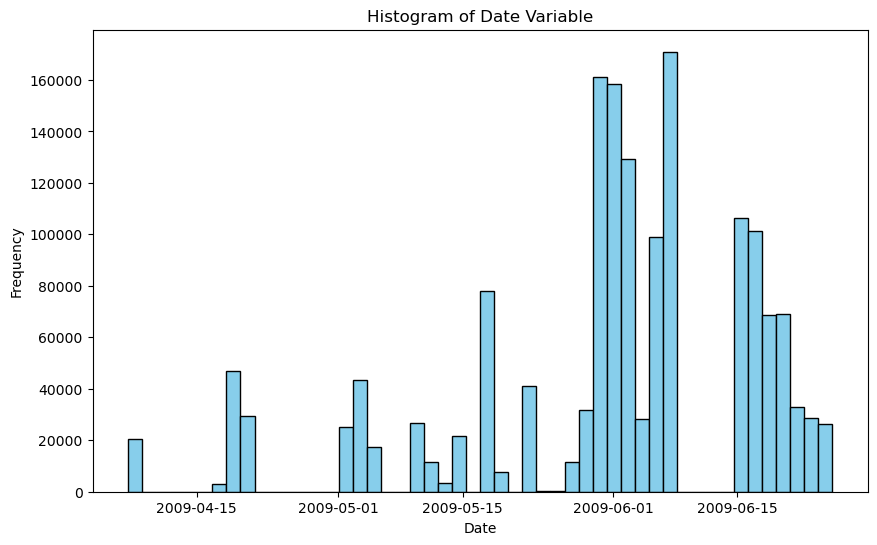

In [16]:
#Histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['date'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Date Variable')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

## Findings
There are missing days 

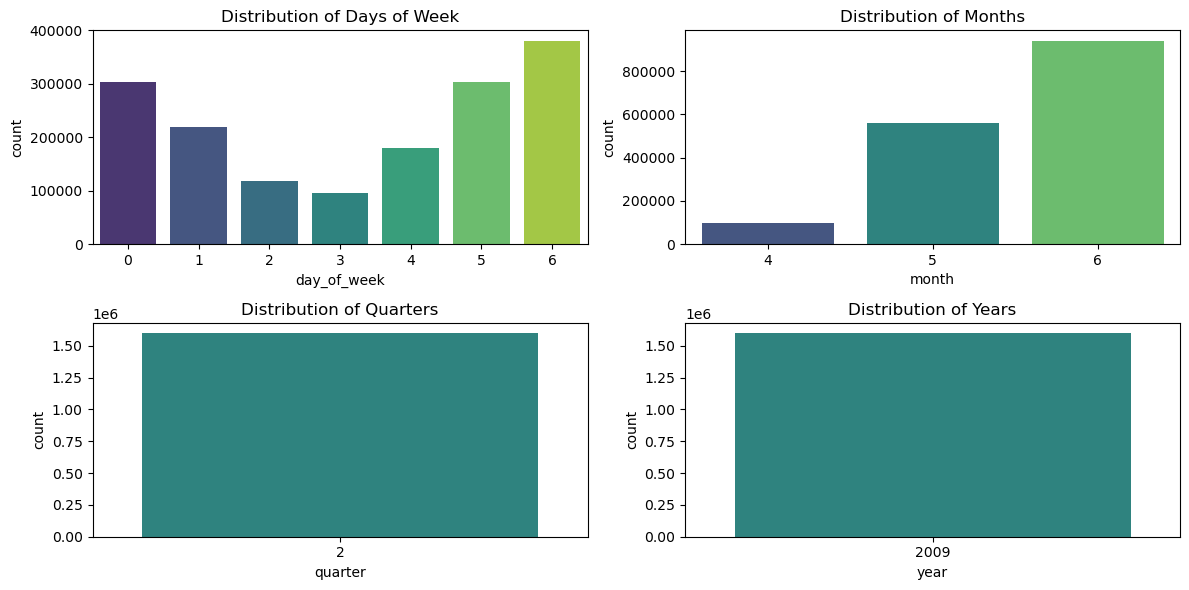

In [17]:
import seaborn as sns
#Extract additional date features for analysis
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

# Plotting distribution of date features
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.countplot(x='day_of_week', data=df, palette='viridis')
plt.title('Distribution of Days of Week')

plt.subplot(2, 2, 2)
sns.countplot(x='month', data=df, palette='viridis')
plt.title('Distribution of Months')

plt.subplot(2, 2, 3)
sns.countplot(x='quarter', data=df, palette='viridis')
plt.title('Distribution of Quarters')

plt.subplot(2, 2, 4)
sns.countplot(x='year', data=df, palette='viridis')
plt.title('Distribution of Years')

plt.tight_layout()
plt.show()

In [18]:
# Extract month from date
df['month'] = df['date'].dt.month

# Group by month and extract sequences
sequences_by_month = {}
for month, group in df.groupby('month'):
    sequences = []
    current_sequence = []
    prev_date = None
    for date in group['date']:
        if prev_date is None or (date - prev_date).days == 1:
            current_sequence.append(date)
        else:
            if len(current_sequence) > 1:
                sequences.append(tuple(current_sequence))  # Convert list to tuple
            current_sequence = [date]
        prev_date = date
    if len(current_sequence) > 1:
        sequences.append(tuple(current_sequence))  # Convert list to tuple
    sequences_by_month[month] = sequences

# Find common sequences among the months
common_sequences = None
for month_sequences in sequences_by_month.values():
    if common_sequences is None:
        common_sequences = set(month_sequences)
    else:
        common_sequences.intersection_update(month_sequences)

# Filter sequences with no missing days
common_sequences_no_missing = []
for seq in common_sequences:
    if pd.date_range(start=seq[0], end=seq[-1]).tolist() == list(seq):  # Convert tuple back to list
        common_sequences_no_missing.append(seq)

# Visualize or return common sequences without missing days
print("Common sequences among all months without missing days:")
for seq in common_sequences_no_missing:
    print(seq)

Common sequences among all months without missing days:


In [19]:
import pandas as pd

#Define date range with correct formatting
date_range = pd.date_range(start="2009-04-07", end="2009-06-25", freq="D")

#Find missing dates
missing_dates = date_range[~date_range.isin(df.index)]
print(missing_dates)
print(len(missing_dates))

DatetimeIndex(['2009-04-07', '2009-04-08', '2009-04-09', '2009-04-10',
               '2009-04-11', '2009-04-12', '2009-04-13', '2009-04-14',
               '2009-04-15', '2009-04-16', '2009-04-17', '2009-04-18',
               '2009-04-19', '2009-04-20', '2009-04-21', '2009-04-22',
               '2009-04-23', '2009-04-24', '2009-04-25', '2009-04-26',
               '2009-04-27', '2009-04-28', '2009-04-29', '2009-04-30',
               '2009-05-01', '2009-05-02', '2009-05-03', '2009-05-04',
               '2009-05-05', '2009-05-06', '2009-05-07', '2009-05-08',
               '2009-05-09', '2009-05-10', '2009-05-11', '2009-05-12',
               '2009-05-13', '2009-05-14', '2009-05-15', '2009-05-16',
               '2009-05-17', '2009-05-18', '2009-05-19', '2009-05-20',
               '2009-05-21', '2009-05-22', '2009-05-23', '2009-05-24',
               '2009-05-25', '2009-05-26', '2009-05-27', '2009-05-28',
               '2009-05-29', '2009-05-30', '2009-05-31', '2009-06-01',
      

In [20]:
# Count the number of dates by month
monthly_date_counts = df.groupby('month').size()

# Display the result
print(monthly_date_counts)


month
4    100025
5    559073
6    940902
dtype: int64


In [21]:
#View the df
df.head(5)

,date,text,user,day,month,day_of_week,quarter,year
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009


## Visualize the count of each day

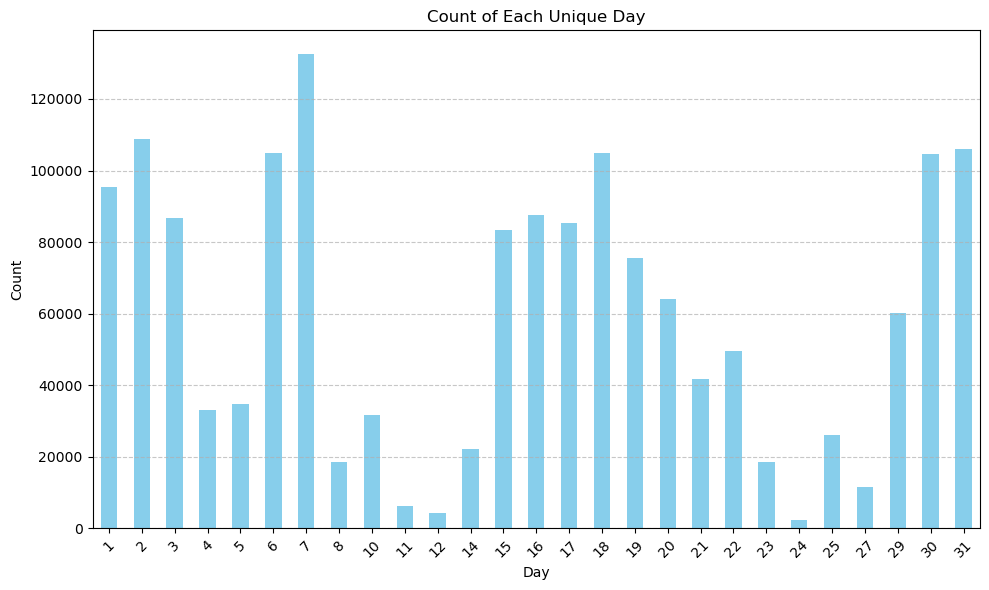

In [22]:
import matplotlib.pyplot as plt
#plot the graph of the days
sorted_days = df['day'].value_counts().sort_index()

# Plotting count of each unique day
plt.figure(figsize=(10, 6))
sorted_days.plot(kind='bar', color='skyblue')
plt.title('Count of Each Unique Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
#Group by month and count the frequency of each unique date within each month
unique_dates_by_month = df.groupby('month')['date'].value_counts()

#Display the result
print(unique_dates_by_month)

month  date               
4      2009-04-18 04:57:42    12
       2009-04-19 00:14:13    11
       2009-04-19 04:22:31    11
       2009-04-19 15:34:51    11
       2009-04-19 17:50:35    11
                              ..
6      2009-06-25 17:28:18     1
       2009-06-25 17:28:19     1
       2009-06-25 17:28:22     1
       2009-06-25 17:28:24     1
       2009-06-25 17:28:31     1
Name: date, Length: 774363, dtype: int64


## Check for duplicates based on date, user and text

In [24]:
import pandas as pd

# Check for duplicates based on user, date, and text
duplicates = df.duplicated(subset=['user', 'date', 'text'], keep=False)

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = df[duplicates]

print("Duplicate rows based on user, date, and text:")
print(duplicate_rows)

Duplicate rows based on user, date, and text:
                       date  \
474     2009-04-07 05:33:35   
480     2009-04-07 05:33:35   
575     2009-04-07 05:38:04   
577     2009-04-07 05:38:04   
2267    2009-04-07 06:28:09   
...                     ...   
1570440 2009-06-23 23:11:03   
1591655 2009-06-25 13:26:14   
1591656 2009-06-25 13:26:14   
1592527 2009-06-25 13:51:59   
1592528 2009-06-25 13:51:59   

                                                      text           user  \
474      Awwh babs... you look so sad underneith that s...       DjGundam   
480      Awwh babs... you look so sad underneith that s...       DjGundam   
575      Haven't tweeted nearly all day  Posted my webs...        iCalvin   
577      Haven't tweeted nearly all day  Posted my webs...        iCalvin   
2267     @hellobebe I also send some updates in plurk b...    mariejamora   
...                                                    ...            ...   
1570440  I effin locked my keys in my hous

# DATA PREPARATION

## Drop Duplicates

In [25]:
#Drop duplicates based on user, text, and date
df = df.drop_duplicates(subset=['user', 'text', 'date'])

print("DataFrame after dropping duplicates based on user, text, and date:")
df

DataFrame after dropping duplicates based on user, text, and date:


,date,text,user,day,month,day_of_week,quarter,year
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009
...,...,...,...,...,...,...,...,...
1599995,2009-06-25 17:28:28,Sick Spending my day laying in bed listening ...,dandykim,25,6,3,2,2009
1599996,2009-06-25 17:28:28,Gmail is down?,bigenya,25,6,3,2,2009
1599997,2009-06-25 17:28:30,rest in peace Farrah! So sad,LeeLHoke,25,6,3,2,2009
1599998,2009-06-25 17:28:30,@Eric_Urbane Sounds like a rival is flagging y...,davidlmulder,25,6,3,2,2009


In [26]:
#Check size of dataset after dropping duplicates
df.shape

(1598127, 8)

In [27]:
#Check if the duplicates based on user, date, and text have been dropped
duplicates = df.duplicated(subset=['user', 'date', 'text'], keep=False)

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = df[duplicates]

print("Duplicate rows based on user, date, and text:")
print(duplicate_rows)

Duplicate rows based on user, date, and text:
Empty DataFrame
Columns: [date, text, user, day, month, day_of_week, quarter, year]
Index: []


## Findings
Duplicates have been dropped.

In [28]:
#Check for Null Rows
df.isnull().sum()

date           0
text           0
user           0
day            0
month          0
day_of_week    0
quarter        0
year           0
dtype: int64

In [29]:
df.head(5)

,date,text,user,day,month,day_of_week,quarter,year
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009


In [30]:
#reset the index after dropping duplicates
df = df.reset_index(drop=True)

# EDA of the Texts

In [31]:
#Count the number of words in the text
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [32]:
df[["text","word_count"]].head(5)

,text,word_count
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",20
1,is upset that he can't update his Facebook by ...,22
2,@Kenichan I dived many times for the ball. Man...,19
3,my whole body feels itchy and like its on fire,11
4,"@nationwideclass no, it's not behaving at all....",22


In [33]:
#Find the maximum number of words in the 'word_count' variable of the 'df' DataFrame
largest_word_count = df["word_count"].max()
largest_word_count

110

In [34]:
#Count the number of characters in the text variable
df['char_count'] = df['text'].str.len() 

In [35]:
#View the head of the char_count and text
df[["text","char_count"]].head(5)

,text,char_count
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,is upset that he can't update his Facebook by ...,111
2,@Kenichan I dived many times for the ball. Man...,89
3,my whole body feels itchy and like its on fire,47
4,"@nationwideclass no, it's not behaving at all....",111


In [36]:
#Find the maximum number of characters in the 'char_count' variable of the 'df' DataFrame
largest_char_count = df["char_count"].max()
largest_char_count

374

In [37]:
#define a function to calculate the average length of words in a sentence
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [38]:
#Apply the avg_word function on text
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

In [39]:
#View text and avg_word
df[['text','avg_word']].head()

,text,avg_word
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",5.052632
1,is upset that he can't update his Facebook by ...,4.285714
2,@Kenichan I dived many times for the ball. Man...,3.944444
3,my whole body feels itchy and like its on fire,3.700000
4,"@nationwideclass no, it's not behaving at all....",4.285714


In [40]:
#Find the highest average word count of the 'df' DataFrame
highest_avg_word = df["avg_word"].max()
highest_avg_word

137.0

In [41]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [42]:
#count number of stopwords in each text and store in a variable called stopwords
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head(5)

,text,stopwords
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4
1,is upset that he can't update his Facebook by ...,8
2,@Kenichan I dived many times for the ball. Man...,5
3,my whole body feels itchy and like its on fire,4
4,"@nationwideclass no, it's not behaving at all....",10


In [43]:
#Find the maximum number of stopwords in the 'df' DataFrame
maximum_no_stopwords = df["stopwords"].max()
maximum_no_stopwords

25

In [44]:
#Count number of hashtags in each text and store in a variable called hastags
df['hashtags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text','hashtags']].head(5)

,text,hashtags
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [45]:
#Find the maximum number of hashtags in the 'df' DataFrame
maximum_no_hashtags = df["hashtags"].max()
maximum_no_hashtags

24

In [46]:
#count number of @ signs in text variable and store the value in a variable called at_sign
df['at_sign'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text','at_sign']].head(5)

,text,at_sign
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,1
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",1


In [47]:
#Find the maximum number of at_sign in the 'df' DataFrame
maximum_no_atsign = df["at_sign"].max()
maximum_no_atsign

12

In [48]:
#count number of numerics in the text variable and store the value in a variable called numeric
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head(5)

,text,numerics
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [49]:
#Find the maximum number of numerics in the 'df' DataFrame
maximum_no_numerics = df["numerics"].max()
maximum_no_numerics

13

In [50]:
#count number of uppercases in the text variable and store the value in a variable called upper
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text','upper']].head(5)

,text,upper
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,1
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",1


In [51]:
#Find the maximum number of uppercases in the 'df' DataFrame
maximum_no_uppercases = df["upper"].max()
maximum_no_uppercases

40

In [52]:
df.isnull().sum()

date           0
text           0
user           0
day            0
month          0
day_of_week    0
quarter        0
year           0
word_count     0
char_count     0
avg_word       0
stopwords      0
hashtags       0
at_sign        0
numerics       0
upper          0
dtype: int64

In [53]:
# Count the duplicate rows in the DataFrame
duplicate_count = df.duplicated().sum()

print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


## Tweets Processing
Tweet/text processing involves:-

a) Text Normalization 
- Remove special characters
- Change the upper cases to lower cases
- Remove numbers/integers
- Remove punctuations
- Remove white space
- Remove URLS/links

b) Tokenization
- Tokenization

c) Remove stopwords

d) Stemming/ lemmatization

## Text Normalization

### Remove user name from text @username

In [54]:
import re

#Define a function to remove user names from text
def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

#Apply the function to the 'text' variable
df['text1'] = df['text'].apply(remove_usernames)

# Print the first few rows of the DataFrame with user names removed from text
print(df['text1'].head())


0     http://twitpic.com/2y1zl - Awww, that's a bum...
1    is upset that he can't update his Facebook by ...
2     I dived many times for the ball. Managed to s...
3      my whole body feels itchy and like its on fire 
4     no, it's not behaving at all. i'm mad. why am...
Name: text1, dtype: object


### Remove url/www.links

In [55]:
import re

def remove_urls(df):
    #Define regex pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    
    #Apply regex substitution to each row of the 'text' column
    df['text1'] = df['text1'].apply(lambda text: re.sub(url_pattern, '', text))
    
    return df

# remove a url
df = remove_urls(df)


In [56]:
df.head(5)

,date,text,user,day,month,day_of_week,quarter,year,word_count,char_count,avg_word,stopwords,hashtags,at_sign,numerics,upper,text1
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009,20,115,5.052632,4,0,1,0,1,"- Awww, that's a bummer. You shoulda got Da..."
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009,22,111,4.285714,8,0,0,0,0,is upset that he can't update his Facebook by ...
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009,19,89,3.944444,5,0,1,0,1,I dived many times for the ball. Managed to s...
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009,11,47,3.700000,4,0,0,0,0,my whole body feels itchy and like its on fire
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009,22,111,4.285714,10,0,1,0,1,"no, it's not behaving at all. i'm mad. why am..."


### Remove all special characters

In [57]:
#Remove all special characters
df['text1'] = df['text1'].str.replace('[^\w\s]','')
df['text1'].head(5)

C:\Users\Diana\AppData\Local\Temp\ipykernel_23160\1096157190.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text1'] = df['text1'].str.replace('[^\w\s]','')


0       Awww thats a bummer  You shoulda got David ...
1    is upset that he cant update his Facebook by t...
2     I dived many times for the ball Managed to sa...
3      my whole body feels itchy and like its on fire 
4     no its not behaving at all im mad why am i he...
Name: text1, dtype: object

### Remove punctuations

In [58]:
#Remove punctuations
import string

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

#Apply remove_punctuation function to the 'text' column
df['text1'] = df['text1'].apply(remove_punctuation)


In [59]:
df.head(5)

,date,text,user,day,month,day_of_week,quarter,year,word_count,char_count,avg_word,stopwords,hashtags,at_sign,numerics,upper,text1
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009,20,115,5.052632,4,0,1,0,1,Awww thats a bummer You shoulda got David ...
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009,22,111,4.285714,8,0,0,0,0,is upset that he cant update his Facebook by t...
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009,19,89,3.944444,5,0,1,0,1,I dived many times for the ball Managed to sa...
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009,11,47,3.700000,4,0,0,0,0,my whole body feels itchy and like its on fire
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009,22,111,4.285714,10,0,1,0,1,no its not behaving at all im mad why am i he...


### Convert all upper cases to lower

In [60]:
#Convert all uppercases to lower cases
df['text1'] = df['text1'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text1'].head(5)

0    awww thats a bummer you shoulda got david carr...
1    is upset that he cant update his facebook by t...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no its not behaving at all im mad why am i her...
Name: text1, dtype: object

## Handling numerics 

In [61]:
import re
import pandas as pd

#Function to remove numbers from text1
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Apply the function to remove numbers to the 'text1
df['text1'] = df['text1'].apply(lambda x: remove_numbers(x))
df['text1'].head(5)

0    awww thats a bummer you shoulda got david carr...
1    is upset that he cant update his facebook by t...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no its not behaving at all im mad why am i her...
Name: text1, dtype: object

## Tokenization

In [62]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

## Word Tokenization

In [63]:
from nltk.tokenize import word_tokenize

#Tokenize the text using NLTK's word tokenizer
df['tokenized_text'] = df['text1'].apply(lambda x: ' '.join(word_tokenize(x.lower())))

#Print the first few rows of the DataFrame with tokenized text
df[['text1', 'tokenized_text']].head(5)

,text1,tokenized_text
0,awww thats a bummer you shoulda got david carr...,awww thats a bummer you shoulda got david carr...
1,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...
2,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...


## Remove stopwords

In [64]:
from nltk.corpus import stopwords

#Download NLTK resources for the first time
nltk.download('stopwords')

#Get the English stopwords list
stop_words = set(stopwords.words('english'))

#Function to remove stopwords
def remove_stopwords(tokenized_text):
    return ' '.join([word for word in tokenized_text.split() if word.lower() not in stop_words])

#Remove stopwords from the tokenized text column
df['tokenized_text'] = df['tokenized_text'].apply(remove_stopwords)

# Print the first few rows of the DataFrame with stopwords removed
print(df[['text1', 'tokenized_text']].head())

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


                                               text1  \
0  awww thats a bummer you shoulda got david carr...   
1  is upset that he cant update his facebook by t...   
2  i dived many times for the ball managed to sav...   
3     my whole body feels itchy and like its on fire   
4  no its not behaving at all im mad why am i her...   

                                      tokenized_text  
0  awww thats bummer shoulda got david carr third...  
1  upset cant update facebook texting might cry r...  
2  dived many times ball managed save rest go bounds  
3                   whole body feels itchy like fire  
4                           behaving im mad cant see  


In [65]:
#Create a Frequency Distribution of the tokenized words
#Import Frequency Distribution
from nltk.probability import FreqDist

#Find frequency distribution of tokenized_text
fdist = FreqDist(df['tokenized_text'])

In [66]:
#Check top 5 common words
fdist.most_common(5)

[('', 7083),
 ('thanks', 2334),
 ('thank', 1576),
 ('get followers day using add everyone train pay vip', 1484),
 ('good morning', 1144)]

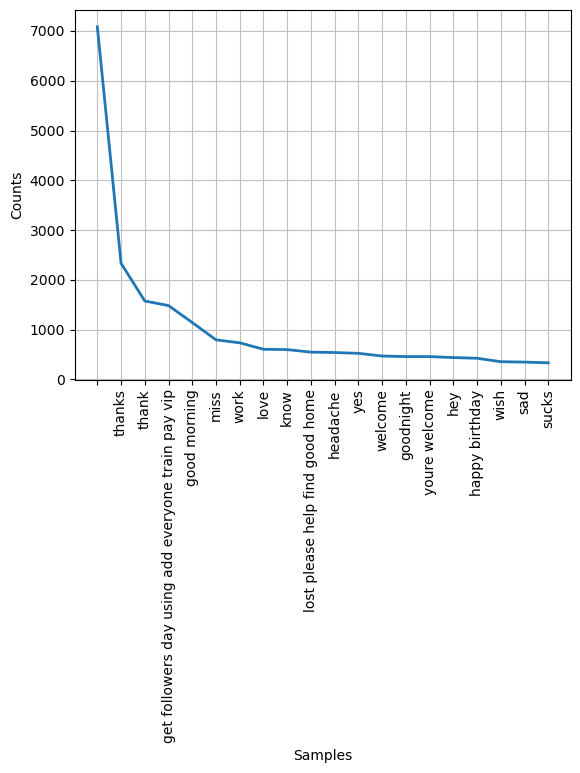

In [67]:
#Create a frequency distribution plot
import matplotlib.pyplot as plt

#Plot Frequency Distribution
fdist.plot(20,cumulative=False)
plt.show()

# Stemming/ lemmatization

In [68]:
from nltk.stem import WordNetLemmatizer

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(tokenized_text):
    #Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokenized_text.split()]
    
    #Join the lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

#Apply lemmatization to 'tokenized_text' column in DataFrame df
df['preprocessed_text'] = df['tokenized_text'].apply(lemmatize_text)

#Print the first few rows of the DataFrame with lemmatized text
print(df[['tokenized_text', 'preprocessed_text']].head(5))

                                      tokenized_text  \
0  awww thats bummer shoulda got david carr third...   
1  upset cant update facebook texting might cry r...   
2  dived many times ball managed save rest go bounds   
3                   whole body feels itchy like fire   
4                           behaving im mad cant see   

                                   preprocessed_text  
0  awww thats bummer shoulda got david carr third...  
1  upset cant update facebook texting might cry r...  
2    dived many time ball managed save rest go bound  
3                    whole body feel itchy like fire  
4                           behaving im mad cant see  


In [69]:
df.isnull().sum()

date                 0
text                 0
user                 0
day                  0
month                0
day_of_week          0
quarter              0
year                 0
word_count           0
char_count           0
avg_word             0
stopwords            0
hashtags             0
at_sign              0
numerics             0
upper                0
text1                0
tokenized_text       0
preprocessed_text    0
dtype: int64

In [70]:
# Count the duplicate rows in the DataFrame
duplicate_count = df.duplicated().sum()

print("Number of duplicate rows:", duplicate_count)


Number of duplicate rows: 0


# SENTIMENT ANALYSIS
There are various ways to perform sentiment analysis. These include:-
- Using Text Blob
- Using Vader
- Using Bag of Words Vectorization-based Models
- Using LSTM-based Models
- Using Transformer-based Models

## USING TEXTBLOB
-  It takes text as an input and can return polarity and subjectivity as outputs.

- Polarity determines the sentiment of the text. Its values lie in [-1,1] where -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.

- Subjectivity determines whether a text input is factual information or a personal opinion. Its value lies between [0,1] where a value closer to 0 denotes a piece of factual information and a value closer to 1 denotes a personal opinion.

In [71]:
from textblob import TextBlob

#Apply sentiment analysis using TextBlob to the 'text' column and storing the polarity score
df['polarity_score'] = df['preprocessed_text'].apply(lambda x: TextBlob(x).sentiment[0] )
df[['preprocessed_text','polarity_score']].head(5)

,preprocessed_text,polarity_score
0,awww thats bummer shoulda got david carr third...,0.200
1,upset cant update facebook texting might cry r...,0.000
2,dived many time ball managed save rest go bound,0.500
3,whole body feel itchy like fire,0.200
4,behaving im mad cant see,-0.625


In [72]:
#View the df, first 5 observations
df.head(5)

,date,text,user,day,month,day_of_week,quarter,year,word_count,char_count,avg_word,stopwords,hashtags,at_sign,numerics,upper,text1,tokenized_text,preprocessed_text,polarity_score
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009,20,115,5.052632,4,0,1,0,1,awww thats a bummer you shoulda got david carr...,awww thats bummer shoulda got david carr third...,awww thats bummer shoulda got david carr third...,0.200
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009,22,111,4.285714,8,0,0,0,0,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...,0.000
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009,19,89,3.944444,5,0,1,0,1,i dived many times for the ball managed to sav...,dived many times ball managed save rest go bounds,dived many time ball managed save rest go bound,0.500
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009,11,47,3.700000,4,0,0,0,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,whole body feel itchy like fire,0.200
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009,22,111,4.285714,10,0,1,0,1,no its not behaving at all im mad why am i her...,behaving im mad cant see,behaving im mad cant see,-0.625


In [73]:
#View data types of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598127 entries, 0 to 1598126
Data columns (total 20 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1598127 non-null  datetime64[ns]
 1   text               1598127 non-null  object        
 2   user               1598127 non-null  object        
 3   day                1598127 non-null  int64         
 4   month              1598127 non-null  int64         
 5   day_of_week        1598127 non-null  int64         
 6   quarter            1598127 non-null  int64         
 7   year               1598127 non-null  int64         
 8   word_count         1598127 non-null  int64         
 9   char_count         1598127 non-null  int64         
 10  avg_word           1598127 non-null  float64       
 11  stopwords          1598127 non-null  int64         
 12  hashtags           1598127 non-null  int64         
 13  at_sign            1598127 

In [74]:
# Function to categorize sentiment polarities
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to classify polarity scores and store the result in 'textblob_sentiment' column
df['textblob_sentiment'] = df['polarity_score'].apply(categorize_sentiment)

# Print the first few rows of the DataFrame with 'textblob_sentiment' column
print(df[['preprocessed_text', 'polarity_score', 'textblob_sentiment']].head())

                                   preprocessed_text  polarity_score  \
0  awww thats bummer shoulda got david carr third...           0.200   
1  upset cant update facebook texting might cry r...           0.000   
2    dived many time ball managed save rest go bound           0.500   
3                    whole body feel itchy like fire           0.200   
4                           behaving im mad cant see          -0.625   

  textblob_sentiment  
0           Positive  
1            Neutral  
2           Positive  
3           Positive  
4           Negative  


# USING VADER SENTIMENT ANALYSIS

In [75]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [76]:
#Create a VADER SentimentIntensityAnalyzer instance
twitter_sentiment = SentimentIntensityAnalyzer()

#Create a function to get compound sentiment score using VADER
def get_sentiment_scores(text):
    return twitter_sentiment.polarity_scores(text)

#Apply the function to get the compound scores and store the values in vader_sentiment
df['vader_sentiment'] = df['preprocessed_text'].apply(get_sentiment_scores)

#Extract the 'neg', 'neu', 'pos', 'compound' scores from 'vader_sentiment'
df['vader_neg'] = df['vader_sentiment'].apply(lambda x: x['neg'])
df['vader_neu'] = df['vader_sentiment'].apply(lambda x: x['neu'])
df['vader_pos'] = df['vader_sentiment'].apply(lambda x: x['pos'])
df['vader_compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])

#Create a function to categorize sentiments based on compound scores
def categorize_sentiment(vader_compound):
    if vader_compound >= 0.05:
        return 'positive'
    elif vader_compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

#Apply the categorization function to create the 'sentiment' column
df['sentiment_vader'] = df['vader_compound'].apply(categorize_sentiment)

#Display the updated DataFrame with the 'sentiment' column
print(df[['preprocessed_text','vader_compound','sentiment_vader']])

                                         preprocessed_text  vader_compound  \
0        awww thats bummer shoulda got david carr third...         -0.3818   
1        upset cant update facebook texting might cry r...         -0.7269   
2          dived many time ball managed save rest go bound          0.4939   
3                          whole body feel itchy like fire         -0.2500   
4                                 behaving im mad cant see         -0.4939   
...                                                    ...             ...   
1598122             sick spending day laying bed listening         -0.5106   
1598123                                              gmail          0.0000   
1598124                              rest peace farrah sad          0.1027   
1598125           sound like rival flagging ad much though          0.3612   
1598126  resit exam summer wish worked harder first yea...          0.4019   

        sentiment_vader  
0              negative  
1          

In [77]:
#View the first 5 observations
df.head(5)

,date,text,user,day,month,day_of_week,quarter,year,word_count,char_count,...,tokenized_text,preprocessed_text,polarity_score,textblob_sentiment,vader_sentiment,vader_neg,vader_neu,vader_pos,vader_compound,sentiment_vader
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009,20,115,...,awww thats bummer shoulda got david carr third...,awww thats bummer shoulda got david carr third...,0.200,Positive,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",0.245,0.755,0.000,-0.3818,negative
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009,22,111,...,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...,0.000,Neutral,"{'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...",0.441,0.559,0.000,-0.7269,negative
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009,19,89,...,dived many times ball managed save rest go bounds,dived many time ball managed save rest go bound,0.500,Positive,"{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...",0.000,0.714,0.286,0.4939,positive
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009,11,47,...,whole body feels itchy like fire,whole body feel itchy like fire,0.200,Positive,"{'neg': 0.45, 'neu': 0.3, 'pos': 0.25, 'compou...",0.450,0.300,0.250,-0.2500,negative
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009,22,111,...,behaving im mad cant see,behaving im mad cant see,-0.625,Negative,"{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...",0.444,0.556,0.000,-0.4939,negative


# Determine which one to use between vader and textblob by evaluating their performance using 

# Using TfidfVectorizer, countvectorizer AND MNB 

### Textblob sentiments

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

#Vectorize the Text Data using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words='english', ngram_range=(1,1))
X = tfidf.fit_transform(df['preprocessed_text'])
y = df['textblob_sentiment']

#Split the data into Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a classifier for MNB
classifier = MultinomialNB()

#Train the Classifier
classifier.fit(X_train, y_train)

#Evaluate the Model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.96      0.65      0.77     65410
     Neutral       0.82      0.81      0.82    118744
    Positive       0.78      0.91      0.84    135472

    accuracy                           0.82    319626
   macro avg       0.85      0.79      0.81    319626
weighted avg       0.83      0.82      0.82    319626



# vader sentiment

In [79]:
#Vectorize the Text Data using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words='english', ngram_range=(1,1))
X = tfidf.fit_transform(df['preprocessed_text'])
y = df['sentiment_vader']

#Split the data into Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a classifier for MNB
classifier = MultinomialNB()

#Train the Classifier
classifier.fit(X_train, y_train)

#Evaluate the Model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.88      0.58      0.70     77131
     neutral       0.75      0.58      0.66     89589
    positive       0.70      0.92      0.80    152906

    accuracy                           0.74    319626
   macro avg       0.78      0.69      0.72    319626
weighted avg       0.76      0.74      0.73    319626



# USING COUNTVECTORIZER

In [80]:
#Pre-Processing using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv    = CountVectorizer(stop_words = 'english',ngram_range = (1, 1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['text'])

C:\Users\Diana\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## textblob sentiments using count vectorizer

In [81]:
#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['textblob_sentiment'], test_size=0.2, random_state=42)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Caluclate the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

Accuracy Score:  0.8343000882281166


## vader sentiments using count vectorizer

In [82]:
#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['sentiment_vader'], test_size=0.25, random_state=5)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Caluclate the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

Accuracy Score:  0.7684565942152318


## Since the accuracy of sentiments extracted by textblob in both countvectorizer and TDIF is higher sentiments extracted by textblob will be used

In [83]:
#Check the variables data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598127 entries, 0 to 1598126
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598127 non-null  datetime64[ns]
 1   text                1598127 non-null  object        
 2   user                1598127 non-null  object        
 3   day                 1598127 non-null  int64         
 4   month               1598127 non-null  int64         
 5   day_of_week         1598127 non-null  int64         
 6   quarter             1598127 non-null  int64         
 7   year                1598127 non-null  int64         
 8   word_count          1598127 non-null  int64         
 9   char_count          1598127 non-null  int64         
 10  avg_word            1598127 non-null  float64       
 11  stopwords           1598127 non-null  int64         
 12  hashtags            1598127 non-null  int64         
 13  at_sign     

# Visualization

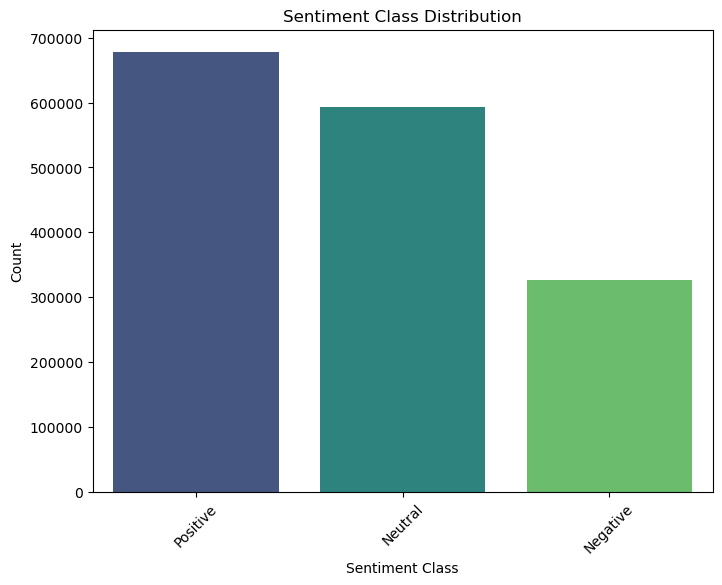

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment class
sentiment_counts = df['textblob_sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [85]:
df.head(5)

,date,text,user,day,month,day_of_week,quarter,year,word_count,char_count,...,tokenized_text,preprocessed_text,polarity_score,textblob_sentiment,vader_sentiment,vader_neg,vader_neu,vader_pos,vader_compound,sentiment_vader
0,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",_TheSpecialOne_,7,4,1,2,2009,20,115,...,awww thats bummer shoulda got david carr third...,awww thats bummer shoulda got david carr third...,0.200,Positive,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",0.245,0.755,0.000,-0.3818,negative
1,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,scotthamilton,7,4,1,2,2009,22,111,...,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...,0.000,Neutral,"{'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...",0.441,0.559,0.000,-0.7269,negative
2,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,mattycus,7,4,1,2,2009,19,89,...,dived many times ball managed save rest go bounds,dived many time ball managed save rest go bound,0.500,Positive,"{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...",0.000,0.714,0.286,0.4939,positive
3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire,ElleCTF,7,4,1,2,2009,11,47,...,whole body feels itchy like fire,whole body feel itchy like fire,0.200,Positive,"{'neg': 0.45, 'neu': 0.3, 'pos': 0.25, 'compou...",0.450,0.300,0.250,-0.2500,negative
4,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",Karoli,7,4,1,2,2009,22,111,...,behaving im mad cant see,behaving im mad cant see,-0.625,Negative,"{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...",0.444,0.556,0.000,-0.4939,negative


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598127 entries, 0 to 1598126
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598127 non-null  datetime64[ns]
 1   text                1598127 non-null  object        
 2   user                1598127 non-null  object        
 3   day                 1598127 non-null  int64         
 4   month               1598127 non-null  int64         
 5   day_of_week         1598127 non-null  int64         
 6   quarter             1598127 non-null  int64         
 7   year                1598127 non-null  int64         
 8   word_count          1598127 non-null  int64         
 9   char_count          1598127 non-null  int64         
 10  avg_word            1598127 non-null  float64       
 11  stopwords           1598127 non-null  int64         
 12  hashtags            1598127 non-null  int64         
 13  at_sign     

# Drop all columns except date and sentiments

In [87]:
df = df[['date','textblob_sentiment','polarity_score']]

In [88]:
df.head(5)

,date,textblob_sentiment,polarity_score
0,2009-04-07 05:19:45,Positive,0.200
1,2009-04-07 05:19:49,Neutral,0.000
2,2009-04-07 05:19:53,Positive,0.500
3,2009-04-07 05:19:57,Positive,0.200
4,2009-04-07 05:19:57,Negative,-0.625


In [89]:
#Count occurrences of each sentiment class
sentiment_textblob = df['textblob_sentiment'].value_counts()

# Display the result as a table
print("Textblob Sentiment Counts:")
print(sentiment_textblob)

Textblob Sentiment Counts:
Positive    678483
Neutral     593056
Negative    326588
Name: textblob_sentiment, dtype: int64


There is class imbalance, in the sentiment data. Class imbalance occurs when one class (or classes) has significantly more samples than the other classes. In this case, the counts of sentiment classes are as follows:

for textblob sentiments

Class positive: 678,483 samples

Class neutral: 593,056 samples

Class negative: 326,588 samples


The class imbalance can potentially affect the performance of the machine learning model, especially if the minority class (in this case, class negative) in textblob

To address class imbalance here are some techniques to be considered:-

- Resampling: Either oversampling the minority class (creating more samples of the minority class) or undersampling the majority class (removing samples from the majority class).

- Class weights: Assigning higher weights to the minority class during model training to give it more importance.

- Synthetic data generation: Generating synthetic samples for the minority class using techniques like SMOTE (Synthetic Minority Over-sampling Technique).

- Different algorithms: Using algorithms that are less sensitive to class imbalance, such as decision trees or random forests.

    


# Handling Missing Dates
- Forward-Filling Method
- Backward-Filling Method
- Linear Interpolation
- Trend and Seasonal Decomposition

In [90]:
df_copy = df.copy()

In [91]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598127 entries, 0 to 1598126
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598127 non-null  datetime64[ns]
 1   textblob_sentiment  1598127 non-null  object        
 2   polarity_score      1598127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.6+ MB


In [92]:
#Sort DataFrame by date in ascending order
df_copy.sort_values(by='date', ascending=True, inplace=True)
#Set 'date' variable as the index
df_copy.set_index('date', inplace=True)  

In [93]:
import pandas as pd
import numpy as np


# Handle missing dates
start_date = df_copy.index.min()
end_date = df_copy.index.max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = all_dates.difference(df_copy.index)
if not missing_dates.empty:
    for date in missing_dates:
        df_copy.loc[date] = np.nan

# Interpolate missing values
df_copy.interpolate(method='linear', inplace=True) 

In [94]:
df_copy.head(5)

,textblob_sentiment,polarity_score
date,,
2009-04-07 05:19:45,Positive,0.200
2009-04-07 05:19:49,Neutral,0.000
2009-04-07 05:19:53,Positive,0.500
2009-04-07 05:19:57,Positive,0.200
2009-04-07 05:19:57,Negative,-0.625


In [95]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1598199 entries, 2009-04-07 05:19:45 to 2009-06-25 05:19:45
Data columns (total 2 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   textblob_sentiment  1598127 non-null  object 
 1   polarity_score      1598199 non-null  float64
dtypes: float64(1), object(1)
memory usage: 36.6+ MB


In [96]:
#Check shape of the df_copy after interporlation
df_copy.shape

(1598199, 2)

In [97]:
#Checking for missing data after interpolation
df_copy.isnull().sum()


textblob_sentiment    72
polarity_score         0
dtype: int64

# Filling the missing values generated after interpolation with modal class of each week

In [98]:
df_copy.head(5)

,textblob_sentiment,polarity_score
date,,
2009-04-07 05:19:45,Positive,0.200
2009-04-07 05:19:49,Neutral,0.000
2009-04-07 05:19:53,Positive,0.500
2009-04-07 05:19:57,Positive,0.200
2009-04-07 05:19:57,Negative,-0.625


In [99]:
df_copy = df_copy.reset_index()

# Check if the index has been reset
print(df_copy.head(5))

                 date textblob_sentiment  polarity_score
0 2009-04-07 05:19:45           Positive           0.200
1 2009-04-07 05:19:49            Neutral           0.000
2 2009-04-07 05:19:53           Positive           0.500
3 2009-04-07 05:19:57           Positive           0.200
4 2009-04-07 05:19:57           Negative          -0.625


In [100]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598199 entries, 0 to 1598198
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598199 non-null  datetime64[ns]
 1   textblob_sentiment  1598127 non-null  object        
 2   polarity_score      1598199 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.6+ MB


In [101]:
import pandas as pd

# Function to impute missing textblob_sentiment values by week
def impute_sentiment_by_week(df_copy):
    mode_sentiments = df_copy.groupby(df_copy['date'].dt.isocalendar().week)['textblob_sentiment'].apply(lambda x: x.mode()[0])
    df_copy['textblob_sentiment'] = df_copy['textblob_sentiment'].fillna(df_copy['date'].dt.isocalendar().week.map(mode_sentiments))
    return df_copy

# Apply function to impute missing textblob_sentiment values
df_copy = df_copy.groupby(df_copy['date'].dt.year, group_keys=True).apply(impute_sentiment_by_week)

print(df_copy)



                            date textblob_sentiment  polarity_score
date                                                               
2009 0       2009-04-07 05:19:45           Positive           0.200
     1       2009-04-07 05:19:49            Neutral           0.000
     2       2009-04-07 05:19:53           Positive           0.500
     3       2009-04-07 05:19:57           Positive           0.200
     4       2009-04-07 05:19:57           Negative          -0.625
...                          ...                ...             ...
     1598194 2009-06-21 05:19:45            Neutral           0.075
     1598195 2009-06-22 05:19:45            Neutral           0.075
     1598196 2009-06-23 05:19:45            Neutral           0.075
     1598197 2009-06-24 05:19:45            Neutral           0.075
     1598198 2009-06-25 05:19:45            Neutral           0.075

[1598199 rows x 3 columns]


In [102]:
#Checking for missing data after interpolation
df_copy.isnull().sum()

date                  0
textblob_sentiment    0
polarity_score        0
dtype: int64

In [103]:
df_copy.head(5)

date textblob_sentiment  polarity_score
date                                                         
2009 0 2009-04-07 05:19:45           Positive           0.200
     1 2009-04-07 05:19:49            Neutral           0.000
     2 2009-04-07 05:19:53           Positive           0.500
     3 2009-04-07 05:19:57           Positive           0.200
     4 2009-04-07 05:19:57           Negative          -0.625

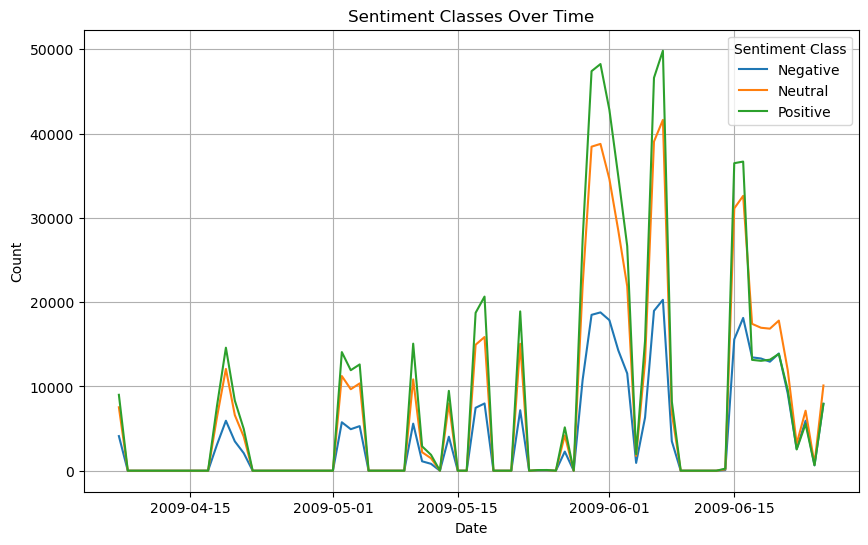

In [104]:
# Set 'date' back to index
df_copy = df_copy.set_index('date')

# Plot time series of sentiment classes
plt.figure(figsize=(10, 6))

# Group by sentiment classes and count occurrences for each date
sentiment_counts = df_copy.groupby([df_copy.index.date, 'textblob_sentiment']).size().unstack(fill_value=0)

# Plot each sentiment class
for sentiment_class in sentiment_counts.columns:
    plt.plot(sentiment_counts.index, sentiment_counts[sentiment_class], label=sentiment_class)

plt.title('Sentiment Classes Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment Class')
plt.grid(True)
plt.show()


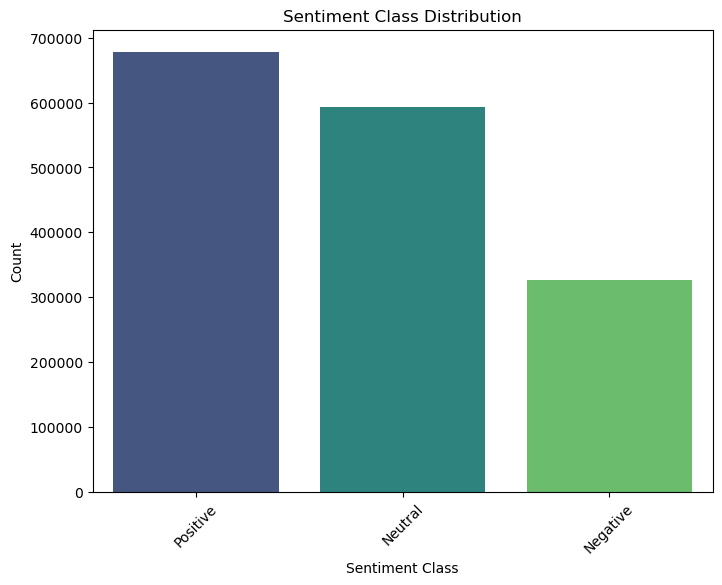

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment class
sentiment_counts = df_copy['textblob_sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import numpy as np

In [107]:
df_copy.head(5)

,textblob_sentiment,polarity_score
date,,
2009-04-07 05:19:45,Positive,0.200
2009-04-07 05:19:49,Neutral,0.000
2009-04-07 05:19:53,Positive,0.500
2009-04-07 05:19:57,Positive,0.200
2009-04-07 05:19:57,Negative,-0.625


In [108]:
# Reset the index
df_copy = df_copy.reset_index()

In [109]:
df_copy.head(5)

,date,textblob_sentiment,polarity_score
0,2009-04-07 05:19:45,Positive,0.200
1,2009-04-07 05:19:49,Neutral,0.000
2,2009-04-07 05:19:53,Positive,0.500
3,2009-04-07 05:19:57,Positive,0.200
4,2009-04-07 05:19:57,Negative,-0.625


In [110]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598199 entries, 0 to 1598198
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598199 non-null  datetime64[ns]
 1   textblob_sentiment  1598199 non-null  object        
 2   polarity_score      1598199 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.6+ MB


# TIME SERIES 
- Fix the class imbalance using techniques like oversampling.
- Aggregate the data by date to get daily sentiment scores.
- Prepare the data for the forecasting models.
- Train and predict using LSTM.
- Train and predict using ARIMA

In [111]:
df_copy = df_copy.reset_index(drop=True)

In [112]:
df_copy.head(5)

,date,textblob_sentiment,polarity_score
0,2009-04-07 05:19:45,Positive,0.200
1,2009-04-07 05:19:49,Neutral,0.000
2,2009-04-07 05:19:53,Positive,0.500
3,2009-04-07 05:19:57,Positive,0.200
4,2009-04-07 05:19:57,Negative,-0.625


In [113]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_copy['label_encoder'] = label_encoder.fit_transform(df_copy['textblob_sentiment'])

In [114]:
df_copy.head(5)

,date,textblob_sentiment,polarity_score,label_encoder
0,2009-04-07 05:19:45,Positive,0.200,2
1,2009-04-07 05:19:49,Neutral,0.000,1
2,2009-04-07 05:19:53,Positive,0.500,2
3,2009-04-07 05:19:57,Positive,0.200,2
4,2009-04-07 05:19:57,Negative,-0.625,0


In [115]:
df_copy.sort_values(by='date', inplace=True)

In [116]:
df_copy.head(5)

,date,textblob_sentiment,polarity_score,label_encoder
0,2009-04-07 05:19:45,Positive,0.200,2
1,2009-04-07 05:19:49,Neutral,0.000,1
2,2009-04-07 05:19:53,Positive,0.500,2
3,2009-04-07 05:19:57,Positive,0.200,2
4,2009-04-07 05:19:57,Negative,-0.625,0


In [117]:
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler  # Import from imbalanced-learn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [118]:
df_copy.head(5)

,date,textblob_sentiment,polarity_score,label_encoder
0,2009-04-07 05:19:45,Positive,0.200,2
1,2009-04-07 05:19:49,Neutral,0.000,1
2,2009-04-07 05:19:53,Positive,0.500,2
3,2009-04-07 05:19:57,Positive,0.200,2
4,2009-04-07 05:19:57,Negative,-0.625,0


In [119]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

def balance_classes(df_copy):


  # Get the sentiment counts
  class_counts = df_copy['textblob_sentiment'].value_counts().sort_values(ascending=False)

  # Find the majority class label and its count
  majority_class = class_counts.index[0]
  majority_count = class_counts.iloc[0]

  # Separate features and target
  X = df_copy['date'].to_numpy().reshape(-1, 1)  # Ensure X is a 2D array
  y = df_copy['textblob_sentiment']

  # Choose the balancing technique based on dataset size
  if len(df_copy) > 2 * majority_count:  # Suitable for large datasets
    # Undersample the majority class (ensure requested samples <= actual samples)
    sampling_strategy = {majority_class: min(len(y[y != majority_class]), majority_count)}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_resampled, y_resampled = rus.fit_resample(X, y)
  else:
    # Oversample the minority class (better for smaller datasets)
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(X, y)

  # Create a new balanced dataframe
  df_balanced = pd.DataFrame({'date': X_resampled.squeeze(), 'textblob_sentiment': y_resampled})

  return df_balanced

# Example usage
df_balanced = balance_classes(df_copy.copy())  # Avoid modifying the original dataframe

# Print the shape to verify class balance (roughly equal counts)
print(df_balanced.shape)


(1598199, 2)


In [120]:
df_balanced.head(5)

,date,textblob_sentiment
0,2009-04-07 05:19:57,Negative
1,2009-04-07 05:20:16,Negative
2,2009-04-07 05:20:44,Negative
3,2009-04-07 05:20:52,Negative
4,2009-04-07 05:21:20,Negative


In [121]:
df_balanced['sentiment_label'] = df_balanced['textblob_sentiment'].map({'Positive': 2,'Neutral': 1, 'Negative': 0})  # Map sentiment to numeric label


In [122]:
df_balanced.head(5)

,date,textblob_sentiment,sentiment_label
0,2009-04-07 05:19:57,Negative,0
1,2009-04-07 05:20:16,Negative,0
2,2009-04-07 05:20:44,Negative,0
3,2009-04-07 05:20:52,Negative,0
4,2009-04-07 05:21:20,Negative,0


In [123]:
# Extract the date part from 'datetext'
df_balanced['date1'] = pd.to_datetime(df_balanced['date']).dt.date

# Create a DataFrame with daily sentiment counts
sentiment_counts = (df_balanced.groupby(['date1'])['textblob_sentiment']
                    .value_counts().unstack(fill_value=0))

# Print the DataFrame with daily sentiment counts
print(sentiment_counts)

textblob_sentiment  Negative  Neutral  Positive
date1                                          
2009-04-07              4109     7526      9008
2009-04-08                 0        0         1
2009-04-09                 0        0         1
2009-04-10                 0        0         1
2009-04-11                 0        0         1
...                      ...      ...       ...
2009-06-21              9161    11921      9595
2009-06-22              2588     3200      2523
2009-06-23              5937     7120      5545
2009-06-24               647      805       642
2009-06-25              7942    10113      7937

[80 rows x 3 columns]


In [124]:
sentiment_counts.head(5)

textblob_sentiment,Negative,Neutral,Positive
date1,,,
2009-04-07,4109,7526,9008
2009-04-08,0,0,1
2009-04-09,0,0,1
2009-04-10,0,0,1
2009-04-11,0,0,1


In [125]:
sentiment_counts.info()


<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 2009-04-07 to 2009-06-25
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Negative  80 non-null     int64
 1   Neutral   80 non-null     int64
 2   Positive  80 non-null     int64
dtypes: int64(3)
memory usage: 2.5+ KB


In [126]:
sentiment_counts= sentiment_counts.reset_index()

In [127]:
sentiment_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date1     80 non-null     object
 1   Negative  80 non-null     int64 
 2   Neutral   80 non-null     int64 
 3   Positive  80 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.6+ KB


# VISUALIZIATION

In [128]:
try:
  # Attempt to convert 'date1' to datetime using potentially common formats
  sentiment_counts['date1'] = pd.to_datetime(sentiment_counts['date1'])
except pd.errors.ParserError:
  # Handle potential parsing errors if the format is unexpected
  print("Error: Could not parse 'date1' column using common formats.")
  # You might need to define a custom parsing function here if the format is specific


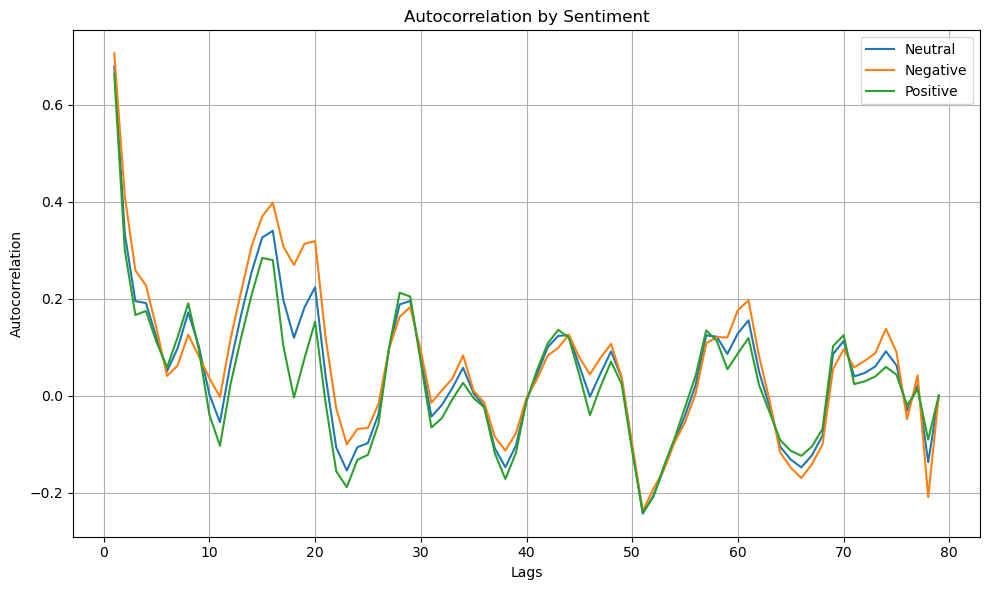

In [130]:
def calculate_autocorrelation(series, max_lag):
  autocorrelations = []
  for lag in range(1, max_lag + 1):
    shifted_series = series.shift(lag)
    covariance = ((series - series.mean()) * (shifted_series - shifted_series.mean())).mean()
    variance = series.var()
    if variance != 0:
      autocorrelation = covariance / variance
    else:
      autocorrelation = np.nan  # Handle potential zero variance
    autocorrelations.append(autocorrelation)
  return autocorrelations

# Assuming your DataFrame is loaded as 'data'

# Check if 'date1' is datetime format (optional)
if not pd.api.types.is_datetime64_dtype(sentiment_counts['date1']):
  # Handle potential conversion if necessary (replace with your logic)
  print("Warning: 'date1' might not be datetime format. ACF plots might not work with Pandas.")

# Calculate and plot ACF for each sentiment category (assuming 'date1' isn't required)
max_lag = 80  # Adjust as needed
neutral_acf = calculate_autocorrelation(sentiment_counts['Neutral'], max_lag)
negative_acf = calculate_autocorrelation(sentiment_counts['Negative'], max_lag)
positive_acf = calculate_autocorrelation(sentiment_counts['Positive'], max_lag)

import matplotlib.pyplot as plt
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot ACF for each sentiment category
plt.plot(range(1, max_lag + 1), neutral_acf, label='Neutral')
plt.plot(range(1, max_lag + 1), negative_acf, label='Negative')
plt.plot(range(1, max_lag + 1), positive_acf, label='Positive')

# Customize the plot layout
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation by Sentiment')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.tight_layout()
plt.show()

In [131]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


<Figure size 1200x800 with 0 Axes>

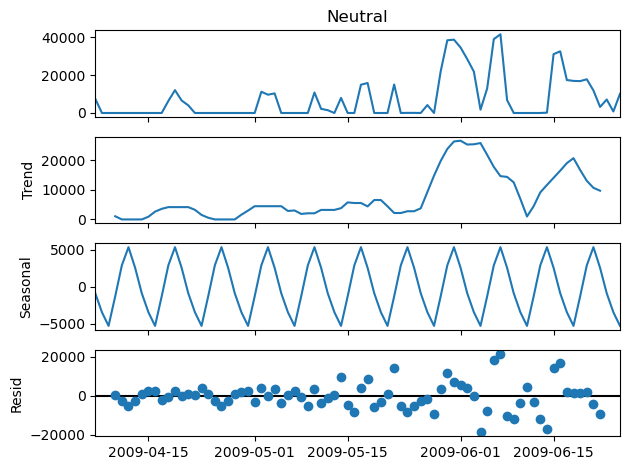

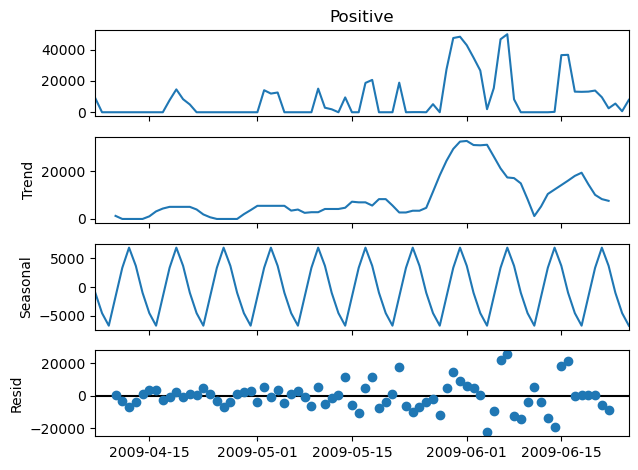

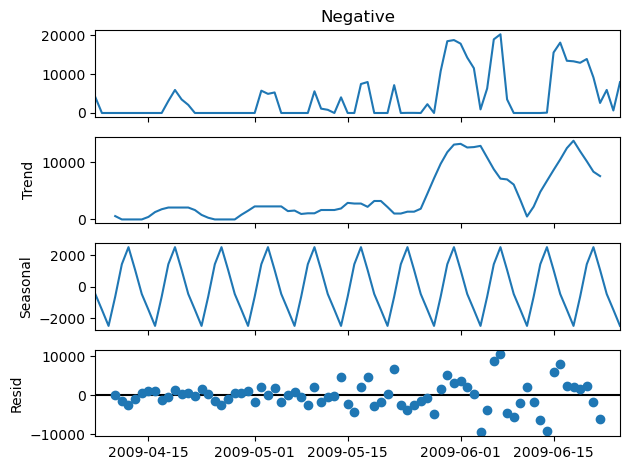

In [132]:
import pandas as pd


sentiment_counts.set_index('date1', inplace=True)  # Set 'date1' as index
sentiment_counts.index = pd.to_datetime(sentiment_counts.index)  # Convert to datetime

# Daily data (adjust frequency as needed)
sentiment_counts.resample('D').fillna(method='ffill').iloc[:-1]  # Resample to daily and handle potential missing values


# Decompose sentiment data addittive
neutral_decomposition = seasonal_decompose(sentiment_counts['Neutral'], model='additive')
positive_decomposition = seasonal_decompose(sentiment_counts['Positive'], model='additive')
negative_decomposition = seasonal_decompose(sentiment_counts['Negative'], model='additive')

# Access trend, seasonal, and residuals components
neutral_trend = neutral_decomposition.trend
neutral_seasonal = neutral_decomposition.seasonal
neutral_residuals = neutral_decomposition.resid

import matplotlib.pyplot as plt

# Plot trend, seasonal, and residuals for Neutral sentiment 
plt.figure(figsize=(12, 8))

neutral_decomposition.plot()
positive_decomposition.plot()
negative_decomposition.plot()

plt.tight_layout()
plt.show()


# DETERMINE IF TIME SERIES IS STATIONARY

In [133]:
sentiment_counts['sentiments'] = sentiment_counts[['Negative', 'Neutral', 'Positive']].apply(pd.Series.sum, axis=1)

In [134]:
sentiment_counts.head(5)

textblob_sentiment,Negative,Neutral,Positive,sentiments
date1,,,,
2009-04-07,4109,7526,9008,20643
2009-04-08,0,0,1,1
2009-04-09,0,0,1,1
2009-04-10,0,0,1,1
2009-04-11,0,0,1,1


Means: [textblob_sentiment
Negative      1088.111111
Neutral       2130.148148
Positive      2615.000000
sentiments    5833.259259
dtype: float64, textblob_sentiment
Negative       2632.407407
Neutral        5313.111111
Positive       6681.037037
sentiments    14626.555556
dtype: float64, textblob_sentiment
Negative       8697.461538
Neutral       15080.653846
Positive      16444.346154
sentiments    40222.461538
dtype: float64]
Standard Deviations: [textblob_sentiment
Negative       1994.873571
Neutral        3922.815254
Positive       4815.758499
sentiments    10731.745473
dtype: float64, textblob_sentiment
Negative       4491.904635
Neutral        9226.891019
Positive      11508.697950
sentiments    25223.654773
dtype: float64, textblob_sentiment
Negative       7337.726161
Neutral       14261.845502
Positive      17439.062135
sentiments    38572.199726
dtype: float64]


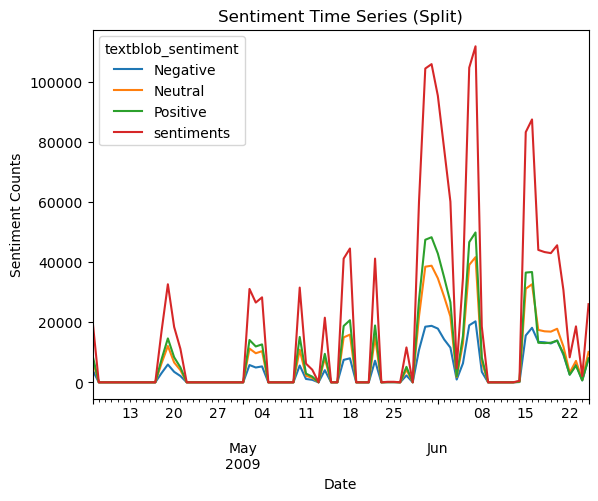

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sentiment_counts' is a pandas Series

num_splits = 3  # Adjust number of splits

# Split the data into chunks (assuming sentiment_counts is a Series)
split_data = np.array_split(sentiment_counts, num_splits)  # Split using numpy

# Calculate means and standard deviations (optional)
means = [chunk.mean() for chunk in split_data]  # List comprehension for means
stds = [chunk.std() for chunk in split_data]  # List comprehension for stds

# Print means and standard deviations (optional)
print("Means:", means)
print("Standard Deviations:", stds)

# Visualize the time series (assuming sentiment_counts has a date index)
sentiment_counts.plot(kind='line')  # Specify line plot for clarity
plt.title('Sentiment Time Series (Split)')
plt.xlabel('Date')  # Use 'Date' if the index represents dates
plt.ylabel('Sentiment Counts')
plt.show()


Here are the means and standard deviations you've provided:

Means:
First split:

Negative: 1088.11
Neutral: 2130.15
Positive: 2615.00
Sentiments: 5833.26
Second split:

Negative: 2632.41
Neutral: 5313.11
Positive: 6681.04
Sentiments: 14626.56
Third split:

Negative: 8697.46
Neutral: 15080.65
Positive: 16444.35
Sentiments: 40222.46
Standard Deviations:
First split:

Negative: 1994.87
Neutral: 3922.82
Positive: 4815.76
Sentiments: 10731.75
Second split:

Negative: 4491.90
Neutral: 9226.89
Positive: 11508.70
Sentiments: 25223.65
Third split:

Negative: 7337.73
Neutral: 14261.85
Positive: 17439.06
Sentiments: 40222.46
The fact that both the means and standard deviations are significantly different across the splits suggests that the data is likely non-stationary. For a time series to be stationary, its mean and variance should remain constant over time.

In [137]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'sentiment_counts' is your time series data (e.g., pandas Series)
result = adfuller(sentiment_counts['sentiments'])

# Extract and display test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

# Interpretation
if result[1] < 0.05:
    print("Reject the null hypothesis - the data is stationary")
else:
    print("Fail to reject the null hypothesis - the data is non-stationary")


ADF Statistic: -4.508186637068076
p-value: 0.00019004955919706284
Critical Value (1%): -3.517113604831504
Critical Value (5%): -2.8993754262546574
Critical Value (10%): -2.5869547797501644
Reject the null hypothesis - the data is stationary


# LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Result for: negative
Best Loss: 0.02531469613313675
Epoch with Best Loss: 94
1/1 [==============================] - 0s 17ms/step
Train Score: 3210.30 RMSE
Test Score: 5487.98 RMSE


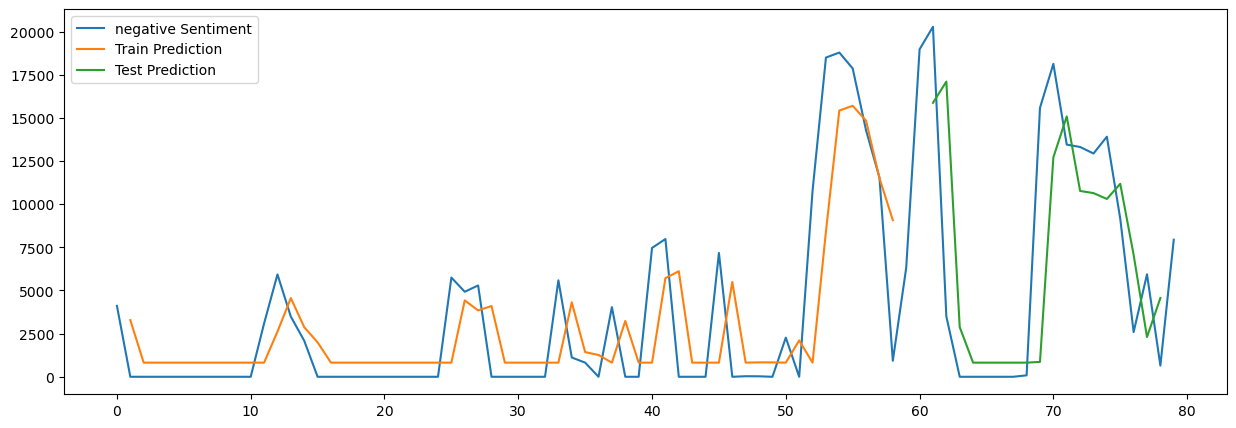

Result for: neutral
Best Loss: 0.023087961599230766
Epoch with Best Loss: 97
1/1 [==============================] - 0s 43ms/step
Train Score: 6301.97 RMSE
Test Score: 10949.84 RMSE


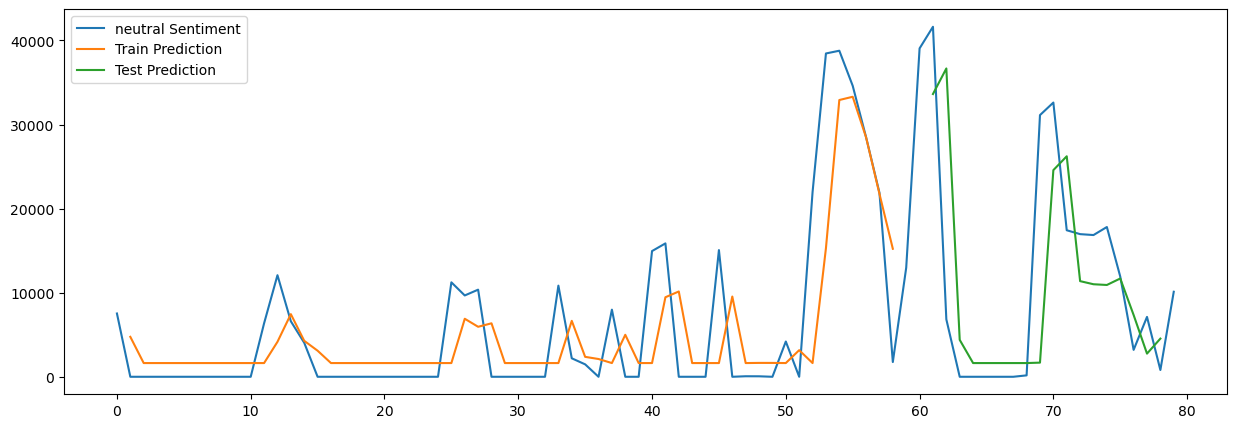

Result for: positive
Best Loss: 0.02451547421514988
Epoch with Best Loss: 87
1/1 [==============================] - 0s 22ms/step
Train Score: 7763.78 RMSE
Test Score: 13431.52 RMSE


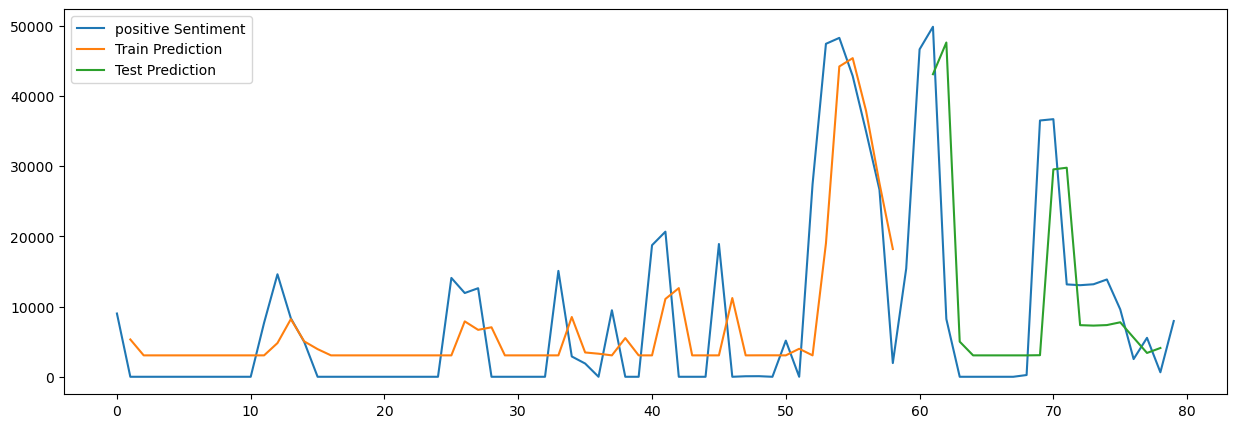

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to preprocess the data for time series forecasting
def preprocessing(sentiment, scaler, look_back):
    sentiment = sentiment.values.reshape(-1, 1)  # Convert Series to NumPy array and reshape

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    # Normalize the dataset
    sentiment = scaler.fit_transform(sentiment)

    # Split into train and test sets
    train_size = int(len(sentiment) * 0.75)
    train, test = sentiment[0:train_size, :], sentiment[train_size:len(sentiment), :]

    # Reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    return trainX, testX, trainY, testY, sentiment

# Sentiment data 
sentiments = {
    'negative': sentiment_counts['Negative'],
    'neutral': sentiment_counts['Neutral'],
    'positive': sentiment_counts['Positive']
}

look_back = 1

# Create and fit the LSTM network
lstm = Sequential()
lstm.add(LSTM(8, input_shape=(1, look_back)))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

for sentiment_name, sentiment_data in sentiments.items():
    # Scaler to normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Call the preprocessing function
    trainX, testX, trainY, testY, sentiment_return = preprocessing(sentiment_data, scaler, look_back)
    
    # Train the LSTM model
    lstm_fit = lstm.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    
    # Access training history
    train_history = lstm_fit.history
    
    # Get the minimum validation loss epoch 
    min_val_loss_epoch = train_history['loss'].index(min(train_history['loss']))

    # Print Results
    print(f'Result for: {sentiment_name}')
    print("Best Loss:", min(train_history['loss']))
    print("Epoch with Best Loss:", min_val_loss_epoch + 1)

    # Make predictions
    trainPredict = lstm.predict(trainX)
    testPredict = lstm.predict(testX)
    
    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    # Calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
    print('Train Score: %.2f RMSE' % trainScore)
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
    print('Test Score: %.2f RMSE' % testScore)

    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(sentiment_return)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
    
    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(sentiment_return)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(sentiment_return) - 1, :] = testPredict
    
    # Inverse transform sentiment data for plotting
    sentiment = scaler.inverse_transform(sentiment_return)
    
    # Plot baseline and predictions
    plt.figure(figsize=(15, 5))
    plt.plot(sentiment, label=f'{sentiment_name} Sentiment')
    plt.plot(trainPredictPlot, label='Train Prediction')
    plt.plot(testPredictPlot, label='Test Prediction')
    plt.legend(loc='upper left')
    plt.show()


In [139]:
  # Define forecast steps
  forecast_steps = [1, 3, 7]

  # Forecast sentiment for each step
  for step in forecast_steps:
    # Get the last element of the test set as the starting point for prediction
    last_test_value = testX[-1]
    # Reshape for prediction (1 sample, 1 time step, features)
    forecast_X = np.reshape(last_test_value, (1, 1, look_back))
    # Forecast sentiment for the specified step
    forecast = lstm.predict(forecast_X)[0][0]
    # Invert scaling for interpretable sentiment value
    forecast = scaler.inverse_transform([[forecast]])[0][0]
    print(f'Forecast for day {step}: {forecast}')


1/1 [==============================] - 0s 20ms/step
Forecast for day 1: 4099.370257690549
1/1 [==============================] - 0s 23ms/step
Forecast for day 3: 4099.370257690549
1/1 [==============================] - 0s 19ms/step
Forecast for day 7: 4099.370257690549


# ARIMA

Result for: negative
Train Score: 3799.92 RMSE
Test Score: 6808.72 RMSE


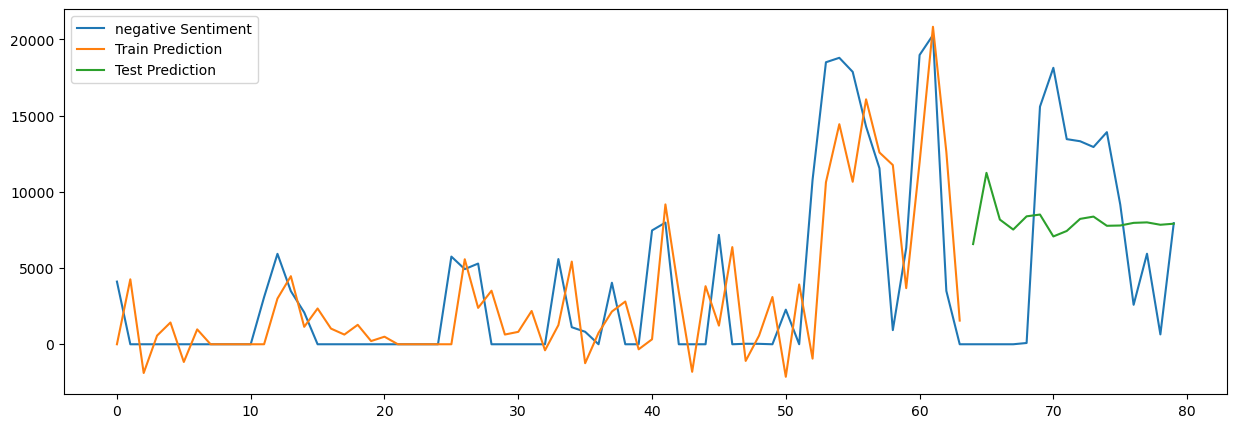

Result for: neutral
Train Score: 7599.85 RMSE
Test Score: 12905.76 RMSE


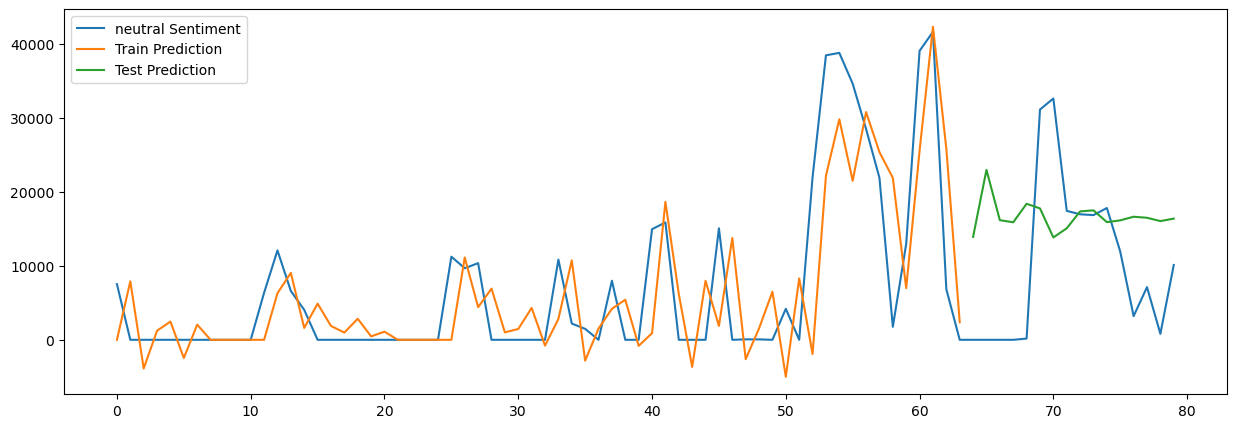

Result for: positive
Train Score: 9394.95 RMSE
Test Score: 15831.49 RMSE


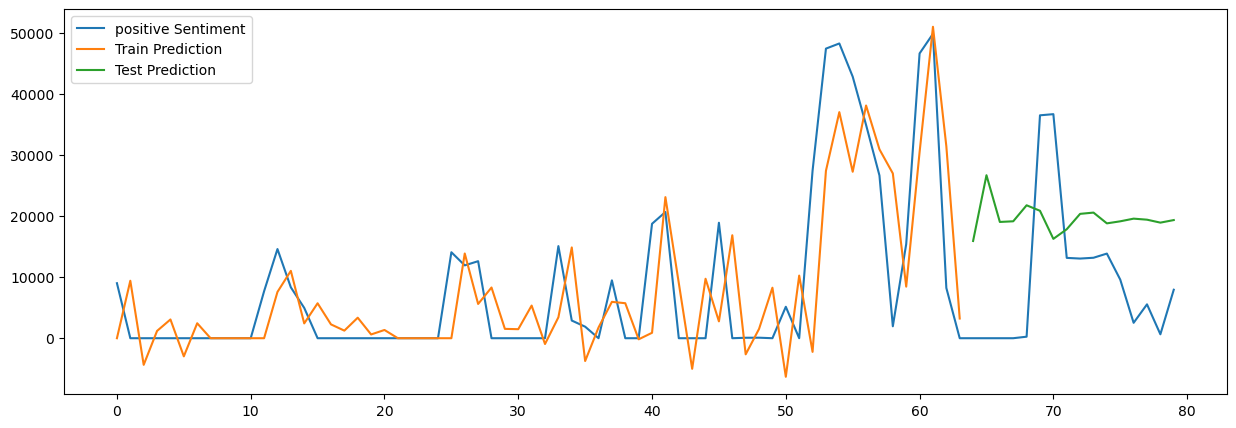

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Function to preprocess the data for ARIMA
def preprocessing(sentiment):
    sentiment = sentiment.values  # Convert Series to NumPy array
    return sentiment

# Sentiment data
sentiments = {
    'negative': sentiment_counts['Negative'],
    'neutral': sentiment_counts['Neutral'],
    'positive': sentiment_counts['Positive']
}

# Parameters for ARIMA
p = 5  # AR term
d = 1  # Differencing
q = 0  # MA term

for sentiment_name, sentiment_data in sentiments.items():
    # Preprocess the data
    sentiment_values = preprocessing(sentiment_data)
    
    # Split into train and test sets
    train_size = int(len(sentiment_values) * 0.80)
    train, test = sentiment_values[0:train_size], sentiment_values[train_size:]
    
    # Fit the ARIMA model
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    
    # Make predictions
    train_predict = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
    test_predict = model_fit.predict(start=len(train), end=len(sentiment_values)-1, dynamic=False)
    
    # Calculate root mean squared error
    train_score = np.sqrt(mean_squared_error(train, train_predict))
    test_score = np.sqrt(mean_squared_error(test, test_predict))
    print(f'Result for: {sentiment_name}')
    print('Train Score: %.2f RMSE' % train_score)
    print('Test Score: %.2f RMSE' % test_score)
    
    # Plot baseline and predictions
    plt.figure(figsize=(15, 5))
    plt.plot(sentiment_values, label=f'{sentiment_name} Sentiment')
    plt.plot(range(len(train)), train_predict, label='Train Prediction')
    plt.plot(range(len(train), len(sentiment_values)), test_predict, label='Test Prediction')
    plt.legend(loc='upper left')
    plt.show()


ARIMA(0, 0, 0) MSE=71687011.479
ARIMA(0, 0, 1) MSE=39648475.089
ARIMA(0, 0, 2) MSE=45940291.409
ARIMA(0, 0, 3) MSE=43511983.037
ARIMA(0, 1, 0) MSE=44176489.600
ARIMA(0, 1, 1) MSE=45708231.820
ARIMA(0, 1, 2) MSE=40076127.859
ARIMA(0, 1, 3) MSE=39094244.613
ARIMA(1, 0, 0) MSE=39564924.686
ARIMA(1, 0, 1) MSE=37060455.055
ARIMA(1, 0, 2) MSE=49232298.223
ARIMA(1, 0, 3) MSE=36414394.275
ARIMA(1, 1, 0) MSE=45123734.578
ARIMA(1, 1, 1) MSE=40511067.922
ARIMA(1, 1, 2) MSE=36853990.842
ARIMA(1, 1, 3) MSE=39344243.870
ARIMA(2, 0, 0) MSE=37358839.305
ARIMA(2, 0, 1) MSE=38455731.619
ARIMA(2, 0, 2) MSE=49230849.055
ARIMA(2, 0, 3) MSE=42047222.618
ARIMA(2, 1, 0) MSE=42652602.860
ARIMA(2, 1, 1) MSE=38616967.503
ARIMA(2, 1, 2) MSE=46522929.705
ARIMA(2, 1, 3) MSE=45430144.723
ARIMA(3, 0, 0) MSE=39007846.209
ARIMA(3, 0, 1) MSE=39978309.552
ARIMA(3, 0, 2) MSE=53206755.678
ARIMA(3, 0, 3) MSE=51143581.380
ARIMA(3, 1, 0) MSE=41608460.443
ARIMA(3, 1, 1) MSE=44160758.021
ARIMA(3, 1, 2) MSE=39252546.529
ARIMA(3,

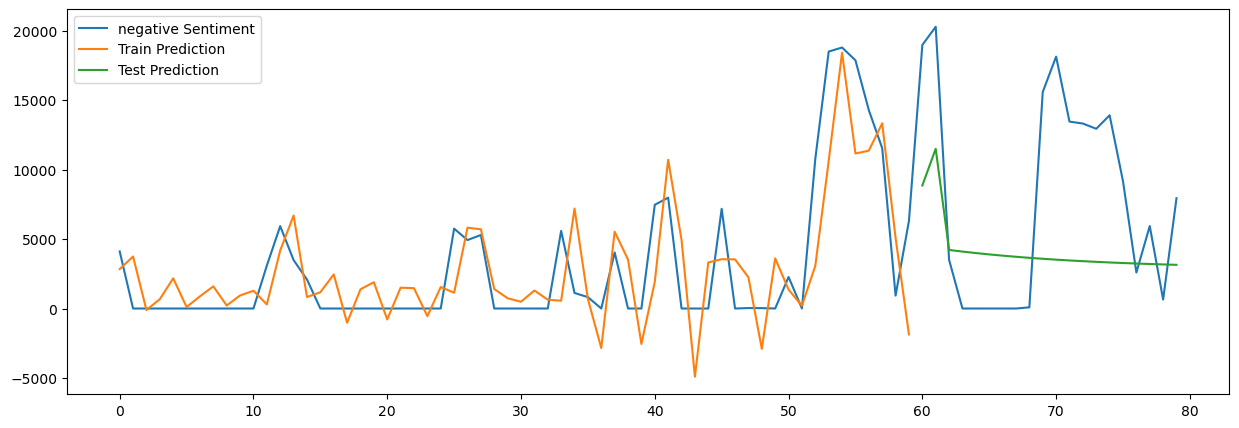

ARIMA(0, 0, 0) MSE=221313771.172
ARIMA(0, 0, 1) MSE=123803971.511
ARIMA(0, 0, 2) MSE=158938641.783
ARIMA(0, 0, 3) MSE=147389575.959
ARIMA(0, 1, 0) MSE=169448520.900
ARIMA(0, 1, 1) MSE=171387650.735
ARIMA(0, 1, 2) MSE=137194781.794
ARIMA(0, 1, 3) MSE=136640514.514
ARIMA(1, 0, 0) MSE=146220740.639
ARIMA(1, 0, 1) MSE=129081742.979
ARIMA(1, 0, 2) MSE=167105854.269
ARIMA(1, 0, 3) MSE=128068643.337
ARIMA(1, 1, 0) MSE=171815573.441
ARIMA(1, 1, 1) MSE=152439663.224
ARIMA(1, 1, 2) MSE=131383625.245
ARIMA(1, 1, 3) MSE=140215605.560
ARIMA(2, 0, 0) MSE=131895512.885
ARIMA(2, 0, 1) MSE=134223417.423
ARIMA(2, 0, 2) MSE=176180187.242
ARIMA(2, 0, 3) MSE=160460940.927
ARIMA(2, 1, 0) MSE=150796526.621
ARIMA(2, 1, 1) MSE=140728016.820
ARIMA(2, 1, 2) MSE=157582554.034
ARIMA(2, 1, 3) MSE=157746715.050
ARIMA(3, 0, 0) MSE=133764976.108
ARIMA(3, 0, 1) MSE=137565009.077
ARIMA(3, 0, 2) MSE=171364051.917
ARIMA(3, 0, 3) MSE=174413424.476
ARIMA(3, 1, 0) MSE=147027729.233
ARIMA(3, 1, 1) MSE=151528995.591
ARIMA(3, 1

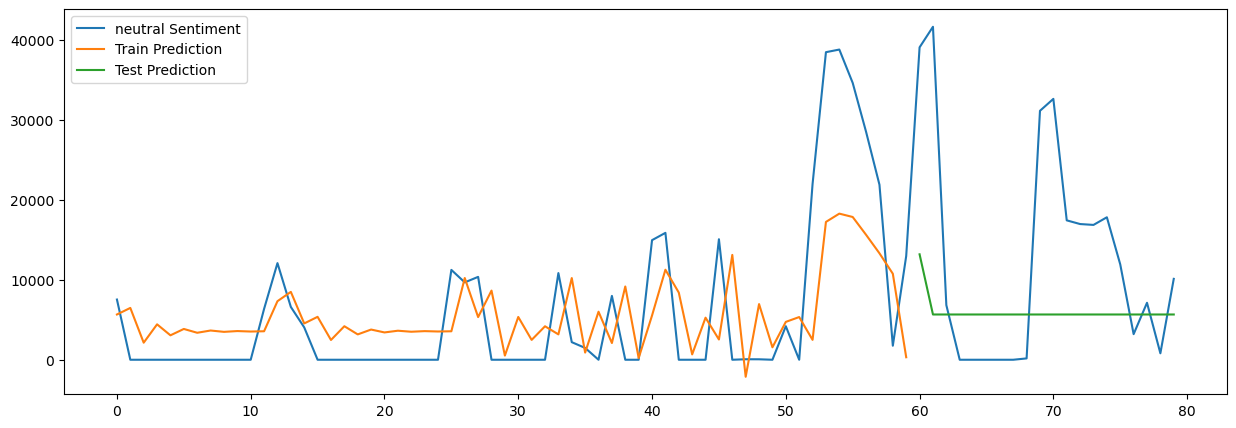

ARIMA(0, 0, 0) MSE=279340334.731
ARIMA(0, 0, 1) MSE=158558380.004
ARIMA(0, 0, 2) MSE=210214554.070
ARIMA(0, 0, 3) MSE=204115360.758
ARIMA(0, 1, 0) MSE=240230330.000
ARIMA(0, 1, 1) MSE=243469402.544
ARIMA(0, 1, 2) MSE=185970426.288
ARIMA(0, 1, 3) MSE=197277640.788
ARIMA(1, 0, 0) MSE=202601011.111
ARIMA(1, 0, 1) MSE=175479903.235
ARIMA(1, 0, 2) MSE=229476026.552
ARIMA(1, 0, 3) MSE=207281310.563
ARIMA(1, 1, 0) MSE=243652556.678
ARIMA(1, 1, 1) MSE=213995243.871
ARIMA(1, 1, 2) MSE=182206470.457
ARIMA(1, 1, 3) MSE=225781595.407
ARIMA(2, 0, 0) MSE=179563320.839
ARIMA(2, 0, 1) MSE=182992457.457
ARIMA(2, 0, 2) MSE=243348416.832
ARIMA(2, 0, 3) MSE=220427739.711
ARIMA(2, 1, 0) MSE=206631799.077
ARIMA(2, 1, 1) MSE=185876490.914
ARIMA(2, 1, 2) MSE=220259602.100
ARIMA(2, 1, 3) MSE=248697129.193
ARIMA(3, 0, 0) MSE=181134108.217
ARIMA(3, 0, 1) MSE=186018047.642
ARIMA(3, 0, 2) MSE=239414025.594
ARIMA(3, 0, 3) MSE=240158300.891
ARIMA(3, 1, 0) MSE=201009940.090
ARIMA(3, 1, 1) MSE=213525632.204
ARIMA(3, 1

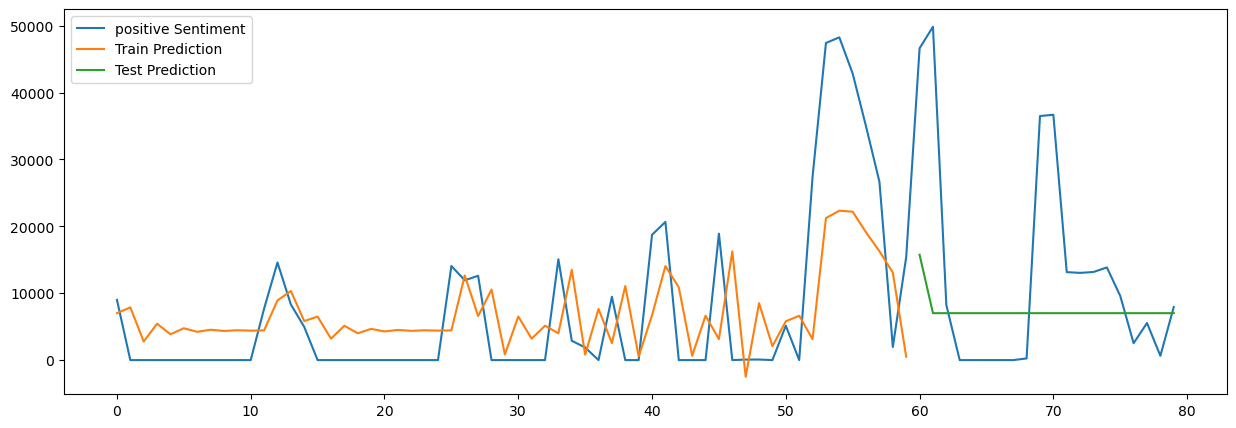

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# Function to preprocess the data for ARIMA
def preprocessing(sentiment):
    sentiment = sentiment.values  # Convert Series to NumPy array
    return sentiment

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

# Function to find the best ARIMA parameters
def grid_search_arima(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(train, test, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARIMA{order} MSE={mse:.3f}')
                except:
                    continue
    print(f'Best ARIMA{best_cfg} MSE={best_score:.3f}')
    return best_cfg

# Sentiment data 
sentiments = {
    'negative': sentiment_counts['Negative'],
    'neutral': sentiment_counts['Neutral'],
    'positive': sentiment_counts['Positive']
}

# ARIMA parameter ranges
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

for sentiment_name, sentiment_data in sentiments.items():
    # Preprocess the data
    sentiment_values = preprocessing(sentiment_data)
    
    # Split into train and test sets
    train_size = int(len(sentiment_values) * 0.75)
    train, test = sentiment_values[:train_size], sentiment_values[train_size:]
    
    # Find the best ARIMA parameters
    best_order = grid_search_arima(train, test, p_values, d_values, q_values)
    
    # Fit the ARIMA model with the best parameters
    model = ARIMA(train, order=best_order)
    model_fit = model.fit()
    
    # Make predictions
    train_predict = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
    test_predict = model_fit.predict(start=len(train), end=len(sentiment_values)-1, dynamic=False)
    
    # Calculate root mean squared error
    train_score = np.sqrt(mean_squared_error(train, train_predict))
    test_score = np.sqrt(mean_squared_error(test, test_predict))
    print(f'Result for: {sentiment_name}')
    print('Train Score: %.2f RMSE' % train_score)
    print('Test Score: %.2f RMSE' % test_score)
    
    # Plot baseline and predictions
    plt.figure(figsize=(15, 5))
    plt.plot(sentiment_values, label=f'{sentiment_name} Sentiment')
    plt.plot(range(len(train)), train_predict, label='Train Prediction')
    plt.plot(range(len(train), len(sentiment_values)), test_predict, label='Test Prediction')
    plt.legend(loc='upper left')
    plt.show()


Result for: negative
Train Score: 3799.92 RMSE
Test Score: 6808.72 RMSE
Forecast for day 1: 6570.22894081378
Forecast for day 3: 8176.679583089519
Forecast for day 7: 7070.9199326744365


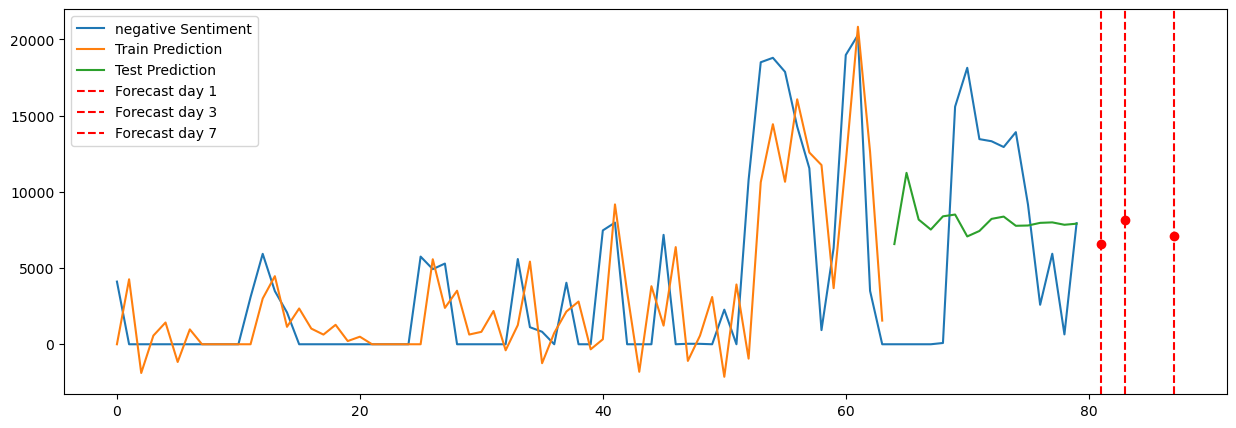

Result for: neutral
Train Score: 7599.85 RMSE
Test Score: 12905.76 RMSE
Forecast for day 1: 13912.247660229728
Forecast for day 3: 16164.82403844619
Forecast for day 7: 13833.7562252716


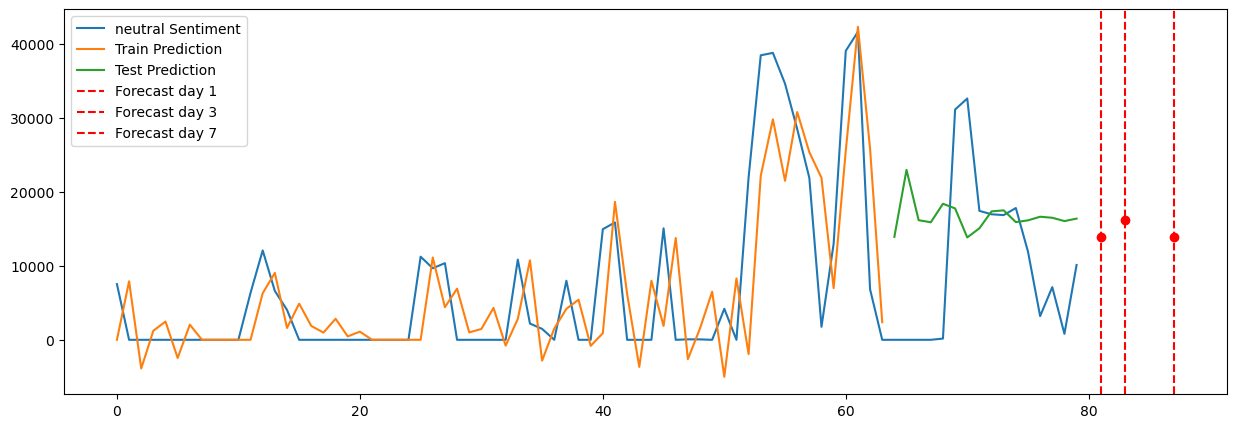

Result for: positive
Train Score: 9394.95 RMSE
Test Score: 15831.49 RMSE
Forecast for day 1: 15917.206705484197
Forecast for day 3: 19033.070749851275
Forecast for day 7: 16263.871082582078


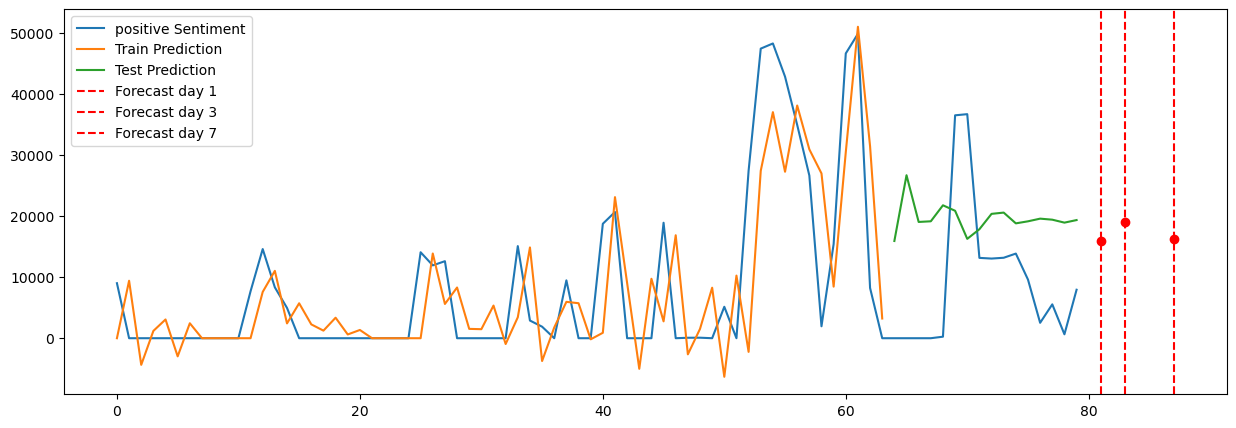

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Function to preprocess the data for ARIMA
def preprocessing(sentiment):
    sentiment = sentiment.values  # Convert Series to NumPy array
    return sentiment

# Sentiment data 
sentiments = {
    'negative': sentiment_counts['Negative'],
    'neutral': sentiment_counts['Neutral'],
    'positive': sentiment_counts['Positive']
}

# Parameters for ARIMA
p = 5  # AR term
d = 1  # Differencing
q = 0  # MA term

for sentiment_name, sentiment_data in sentiments.items():
    # Preprocess the data
    sentiment_values = preprocessing(sentiment_data)
    
    # Split into train and test sets
    train_size = int(len(sentiment_values) * 0.80)
    train, test = sentiment_values[0:train_size], sentiment_values[train_size:]
    
    # Fit the ARIMA model
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    
    # Make predictions
    train_predict = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
    test_predict = model_fit.predict(start=len(train), end=len(sentiment_values)-1, dynamic=False)
    
    # Calculate root mean squared error
    train_score = np.sqrt(mean_squared_error(train, train_predict))
    test_score = np.sqrt(mean_squared_error(test, test_predict))
    print(f'Result for: {sentiment_name}')
    print('Train Score: %.2f RMSE' % train_score)
    print('Test Score: %.2f RMSE' % test_score)
    
    # Forecast future values for day 1, 3, and 7
    forecast_steps = [1, 3, 7]
    forecasts = {}
    for step in forecast_steps:
        forecast = model_fit.forecast(steps=step)[-1]  # Get the forecast for the specific step
        forecasts[step] = forecast
        print(f'Forecast for day {step}: {forecast}')
    
    # Plot baseline, predictions, and forecasts
    plt.figure(figsize=(15, 5))
    plt.plot(sentiment_values, label=f'{sentiment_name} Sentiment')
    plt.plot(range(len(train)), train_predict, label='Train Prediction')
    plt.plot(range(len(train), len(sentiment_values)), test_predict, label='Test Prediction')
    
    # Mark the forecast points
    for step, forecast in forecasts.items():
        plt.axvline(x=len(sentiment_values) + step, color='r', linestyle='--', label=f'Forecast day {step}')
        plt.scatter(len(sentiment_values) + step, forecast, color='r')
    
    plt.legend(loc='upper left')
    plt.show()


# DYNAMIC DASHBOARD

In [144]:
!pip install streamlit


2024-05-19 20:19:01.711 
  command:

    streamlit run C:\Users\Diana\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

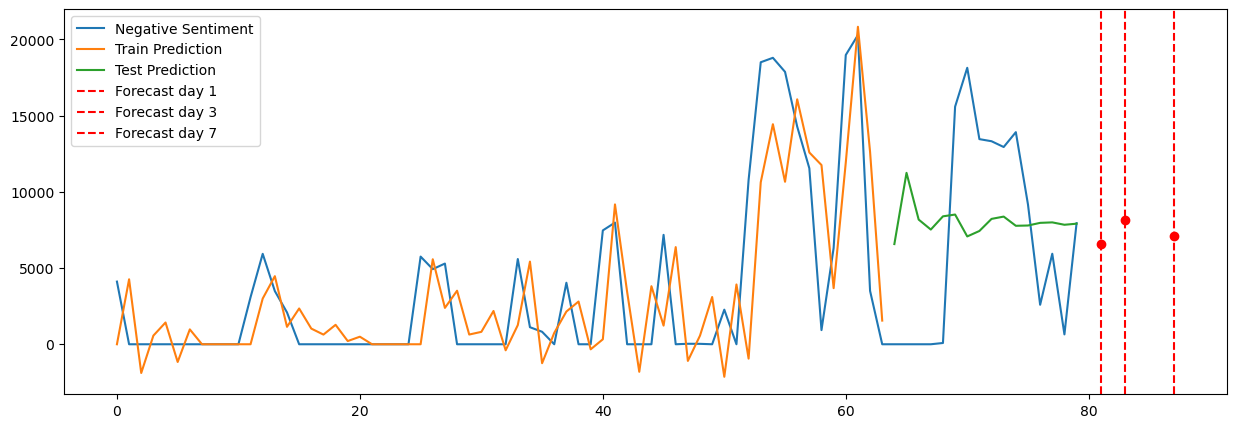

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import streamlit as st

# Function to preprocess the data for ARIMA
def preprocessing(sentiment):
    sentiment = sentiment.values  # Convert Series to NumPy array
    return sentiment

# Streamlit dashboard layout
st.title("Sentiment Analysis with ARIMA Model")

# Sidebar for user input
st.sidebar.title("ARIMA Model Configuration")
selected_sentiment = st.sidebar.selectbox("Select Sentiment", options=list(sentiment_counts.keys()))
p = st.sidebar.number_input("AR term (p)", min_value=0, max_value=10, value=5)
d = st.sidebar.number_input("Differencing (d)", min_value=0, max_value=2, value=1)
q = st.sidebar.number_input("MA term (q)", min_value=0, max_value=10, value=0)

# Main section to display results
st.write(f"Selected Sentiment: {selected_sentiment}")
sentiment_data = sentiment_counts[selected_sentiment]

# Preprocess the data
sentiment_values = preprocessing(sentiment_data.dropna())

# Split into train and test sets
train_size = int(len(sentiment_values) * 0.80)
train, test = sentiment_values[0:train_size], sentiment_values[train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Make predictions
train_predict = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
test_predict = model_fit.predict(start=len(train), end=len(sentiment_values)-1, dynamic=False)

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(train, train_predict))
test_score = np.sqrt(mean_squared_error(test, test_predict))
st.write(f'Train Score: {train_score:.2f} RMSE')
st.write(f'Test Score: {test_score:.2f} RMSE')

# Forecast future values for day 1, 3, and 7
forecast_steps = [1, 3, 7]
forecasts = {}
for step in forecast_steps:
    forecast = model_fit.forecast(steps=step)[-1]  # Get the forecast for the specific step
    forecasts[step] = forecast
    st.write(f'Forecast for day {step}: {forecast}')

# Plot baseline, predictions, and forecasts
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sentiment_values, label=f'{selected_sentiment} Sentiment')
ax.plot(range(len(train)), train_predict, label='Train Prediction')
ax.plot(range(len(train), len(sentiment_values)), test_predict, label='Test Prediction')

# Mark the forecast points
for step, forecast in forecasts.items():
    ax.axvline(x=len(sentiment_values) + step, color='r', linestyle='--', label=f'Forecast day {step}')
    ax.scatter(len(sentiment_values) + step, forecast, color='r')

ax.legend(loc='upper left')
st.pyplot(fig)
